# Product Quantization Experiments

## Implementation overview

Importing libraries:

In [1]:
import time
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from search_approaches import PQ, IVF, ExactSearch
from utils import *

In [2]:
help(PQ)

Help on class PQ in module search_approaches:

class PQ(builtins.object)
 |  PQ(M: int = 8, K: int = 256, kmeans_iter: int = 300, kmeans_minit: str = 'k-means++', seed: int = None, orth_transf: bool = False, part_alg: str = None, dim_reduction: bool = False)
 |  
 |  Product Quantization (PQ) implementation.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, M: int = 8, K: int = 256, kmeans_iter: int = 300, kmeans_minit: str = 'k-means++', seed: int = None, orth_transf: bool = False, part_alg: str = None, dim_reduction: bool = False)
 |      Constructor.
 |      
 |      Parameters
 |      ----------
 |      
 |      M : int, default=8
 |          Number of subspaces.
 |      
 |      K : int, default=256
 |          Number of clusters per subspace.
 |      
 |      kmeans_iter : int, default=300
 |          Maximum number of iterations for KMeans.
 |      
 |      kmeans_minit : str, default='k-means++'
 |          Method for KMeans initialization.
 |          See https://scikit-l

In [3]:
help(IVF)

Help on class IVF in module search_approaches:

class IVF(builtins.object)
 |  IVF(Kp: int = 1024, M: int = 8, K: int = 256, kmeans_iter: int = 300, kmeans_minit: str = 'k-means++', seed: int = None, orth_transf: bool = False, part_alg: str = None, dim_reduction: bool = False, bisectingkmeans: bool = False)
 |  
 |  Inverted File (IVF) implementation with Product Quantization (PQ).
 |  
 |  Methods defined here:
 |  
 |  __init__(self, Kp: int = 1024, M: int = 8, K: int = 256, kmeans_iter: int = 300, kmeans_minit: str = 'k-means++', seed: int = None, orth_transf: bool = False, part_alg: str = None, dim_reduction: bool = False, bisectingkmeans: bool = False)
 |      Constructor.
 |      
 |      Parameters
 |      ----------
 |      
 |      Kp: int, default=1024
 |          Number of centroids for the coarse quantizer.
 |      
 |      M : int, default=8
 |          Number of subspaces for the PQ quantizer.
 |      
 |      K : int, default=256
 |          Number of clusters per subspa

## Dataset exploration

Defining constants:

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "siftsmall" # "sift", "glove"
DIR = "siftsmall" # "sift", "glove"
tab20 = matplotlib.colormaps["tab20"]
tab10 = matplotlib.colormaps["tab10"]

Loading the data:

In [5]:
if DATASET == "sift" or DATASET == "siftsmall":
    search_data, queries, tr_data, gt = load_sift(name=DATASET, dir=DIR)
else:
    with open(f"{DIR}/glove_data.pkl", "rb") as f:
        tr_data, search_data, queries = pickle.load(f)

sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))
print("Search vectors shape: ", search_data.shape)
print(f"Base vectors range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
if DATASET == "sift" or DATASET == "siftsmall":
    print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", tr_data.shape)
print("Query example:\n", queries[0])

Search vectors shape:  (10000, 128)
Base vectors range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (25000, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


Visualizing the data:

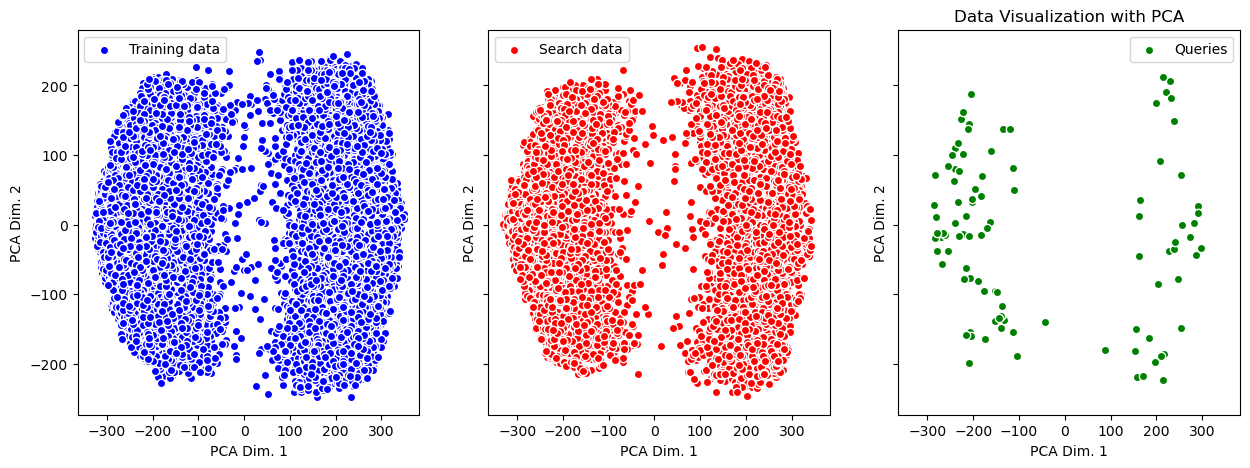

In [6]:
data = np.concatenate([tr_data, search_data, queries], axis=0)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
tr_data_pca = data_pca[:len(tr_data)]
search_data_pca = data_pca[len(tr_data) : len(tr_data)+len(search_data)]
queries_pca = data_pca[len(tr_data)+len(search_data) : ]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axs[0].scatter(x=tr_data_pca[:, 0], y=tr_data_pca[:, 1], color='blue', label='Training data', edgecolors='white')
axs[1].scatter(x=search_data_pca[:, 0], y=search_data_pca[:, 1], color='red', label='Search data', edgecolors='white')
axs[2].scatter(x=queries_pca[:, 0], y=queries_pca[:, 1], color='green', label='Queries', edgecolors='white')

for i in range(3):
    axs[i].set_xlabel('PCA Dim. 1')
    axs[i].set_ylabel('PCA Dim. 2')
    axs[i].legend()

plt.title("Data Visualization with PCA")
plt.show()

# tsne = TSNE(n_components=2, perplexity=5, random_state=RANDOM_SEED)
# data_tsne = tsne.fit_transform(data)
# tr_data_tsne = data_tsne[:len(tr_data)]
# search_data_tsne = data_tsne[len(tr_data):len(tr_data) + len(search_data)]
# queries_tsne = data_tsne[len(tr_data) + len(search_data):]

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# axs[0].scatter(x=tr_data_tsne[:, 0], y=tr_data_tsne[:, 1], color='blue', label='Training data', edgecolors='white')
# axs[1].scatter(x=search_data_tsne[:, 0], y=search_data_tsne[:, 1], color='red', label='Search data', edgecolors='white')
# axs[2].scatter(x=queries_tsne[:, 0], y=queries_tsne[:, 1], color='green', label='Queries', edgecolors='white')

# for i in range(3):
#     axs[i].set_xlabel('t-SNE Dim. 1')
#     axs[i].set_ylabel('t-SNE Dim. 2')
#     axs[i].legend()

# plt.title("Data Visualization with t-SNE")
# plt.show()

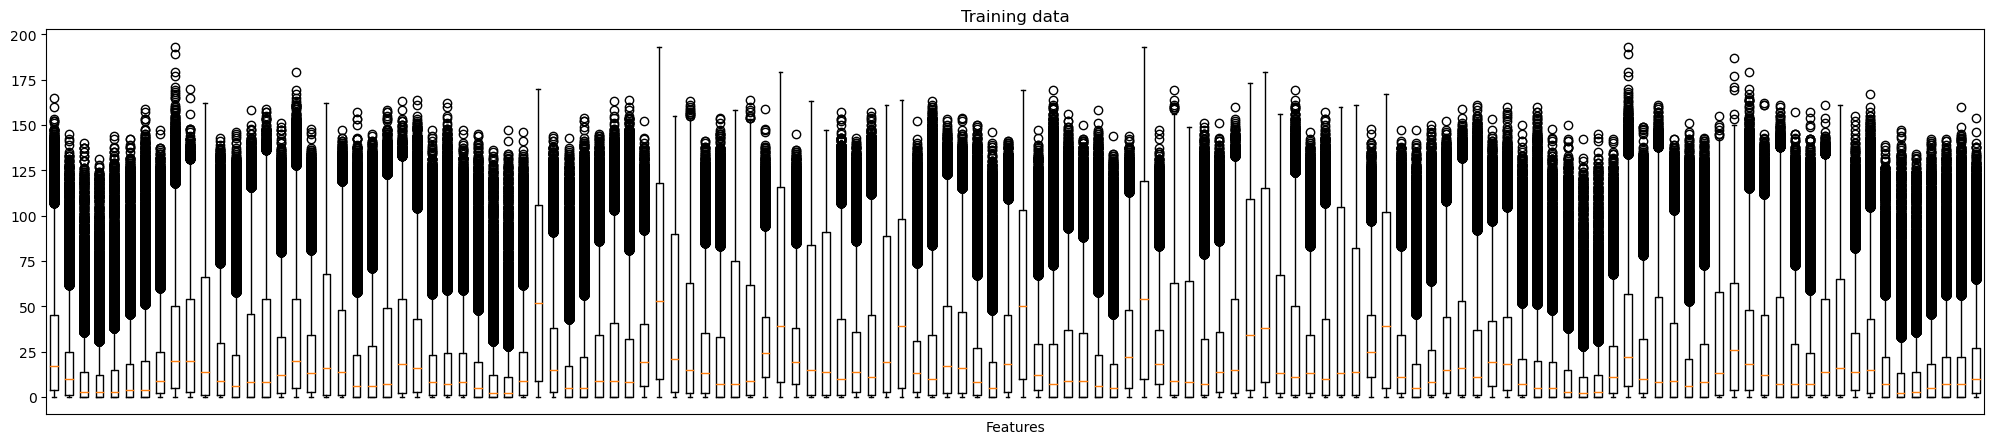

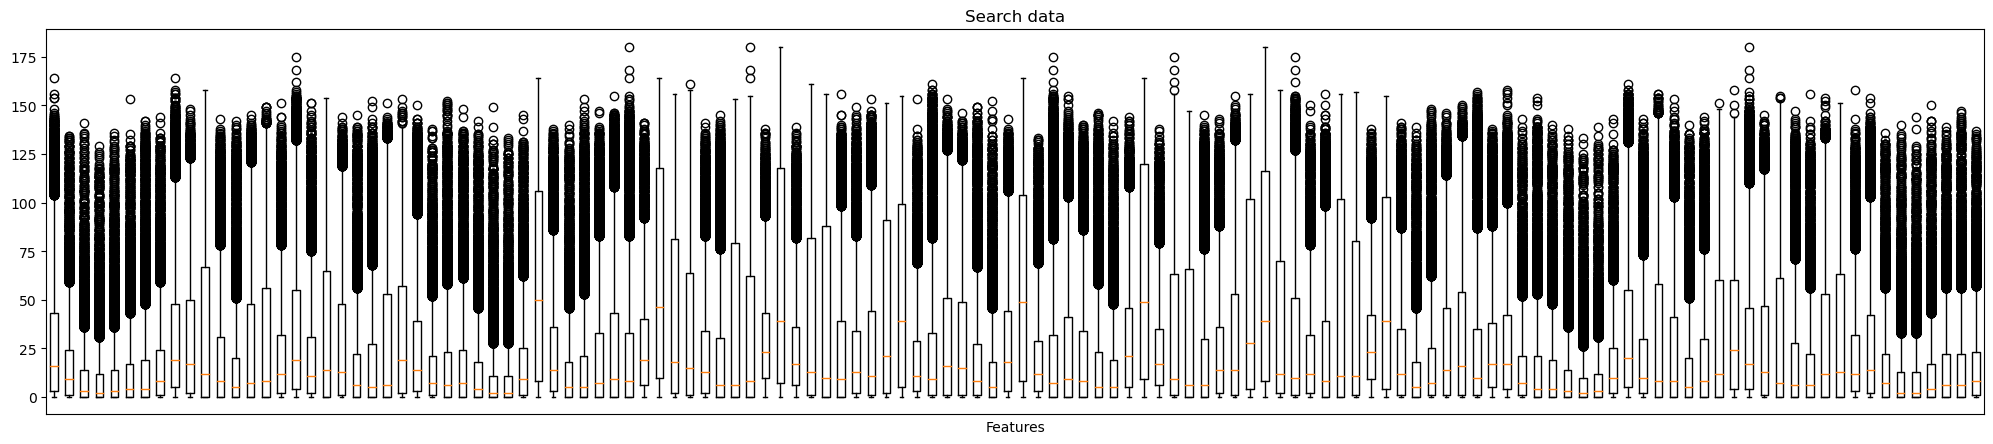

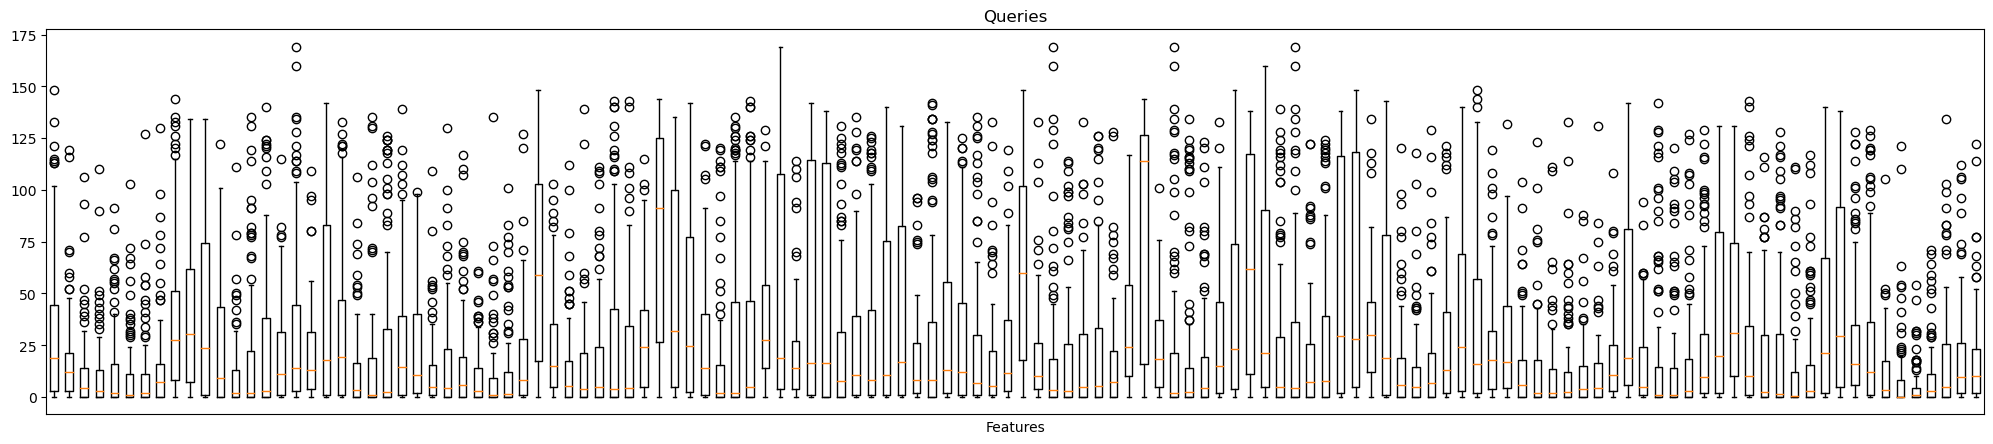

In [7]:
if DATASET != "glove": # glove data has too many features
    plt.figure(figsize=(25, 5))
    plt.boxplot(tr_data)
    plt.title("Training data")
    plt.xticks([])
    plt.xlabel("Features")
    plt.figure(figsize=(25, 5))
    plt.boxplot(search_data)
    plt.title("Search data")
    plt.xticks([])
    plt.xlabel("Features")
    plt.figure(figsize=(25, 5))
    plt.boxplot(queries)
    plt.title("Queries")
    plt.xticks([])
    plt.xlabel("Features");

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



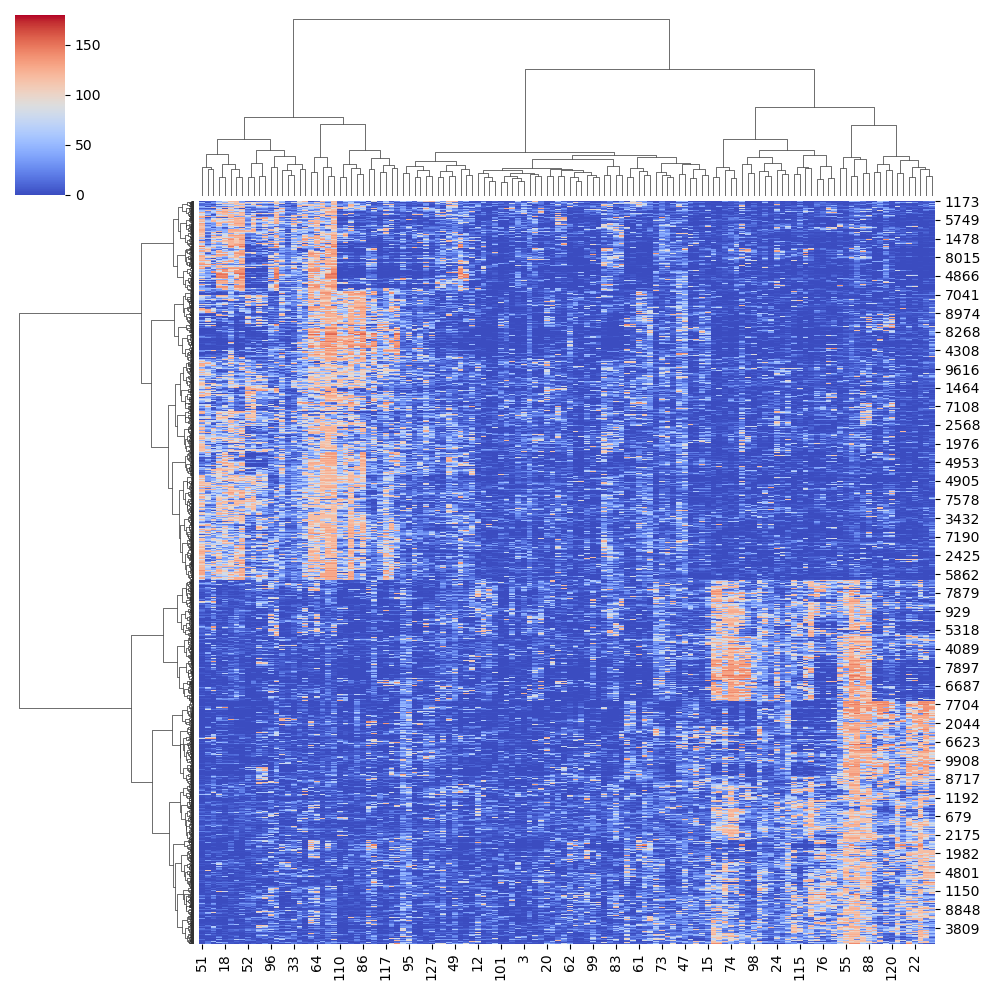

In [8]:
if DATASET != "sift": # sift data is too large
    sns.clustermap(search_data, metric='euclidean', cmap='coolwarm', method='ward', figsize=(10, 10))
    plt.show()

## Replication of the results from the article

### Product Quantization without inverted file index

Training the PQ quantizer:

In [9]:
M = 20 if DATASET == "glove" else 8
K = 256
pq = PQ(M=M, K=K, seed=RANDOM_SEED)

print(f"Training the PQ quantizer with M={M}, K={K}"
    " (chunk size = {tr_data.shape[1] / M})...")

start_training = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time = time.time() - start_training
start_adding = time.time()
pq.add(search_data)
adding_time = time.time() - start_adding

compressed_tr = pq.compress(tr_data)
decompressed_tr = pq.decompress(compressed_tr) 
error_tr = NMSE(tr_data, decompressed_tr)

decompressed_search = pq.decompress(pq.pqcode)
error_search = NMSE(search_data, decompressed_search)

results = [{
    "Training time [s]": training_time,
    "Adding time [s]": adding_time,
    "Compressed data shape": f"{pq.pqcode.shape}",
    "Compressed data size [bytes]": pq.pqcode.nbytes,
    "Original data size [bytes]": tr_data.nbytes,
    "Compression factor": tr_data.nbytes / pq.pqcode.nbytes,
    "NMSE on training data": error_tr,
    "NMSE on search data": error_search
}]

print("--------------------")
print(f"Training the PQ quantizer with M={M}, K={K}"
    " (chunk size = {tr_data.shape[1] / M}) and average distortion"
    " computation...")

start_training_d = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time_d = time.time() - start_training_d
start_adding_d = time.time()
pq.add(search_data, compute_distortions=True)
adding_time_d = time.time() - start_adding_d

results.append({
    "Training time [s]": training_time_d,
    "Adding time [s]": adding_time_d,
    "Compressed data shape": f"{pq.pqcode.shape} + {pq.avg_dist.shape}",
    "Compressed data size [bytes]": pq.pqcode.nbytes + pq.avg_dist.nbytes,
    "Original data size [bytes]": tr_data.nbytes,
    "Compression factor": tr_data.nbytes / (pq.pqcode.nbytes + pq.avg_dist.nbytes),
    "NMSE on training data": error_tr,
    "NMSE on search data": error_search
})

pd.DataFrame(
    results,
    index=["Without average distortion", "With average distortion"]
    ).style.background_gradient(cmap="Blues")

Training the PQ quantizer with M=8, K=256 (chunk size = {tr_data.shape[1] / M})...
KMeans on subspace 1 converged in 77 iterations with an inertia of 61875936.0.
KMeans on subspace 2 converged in 79 iterations with an inertia of 64370024.0.
KMeans on subspace 3 converged in 60 iterations with an inertia of 78925296.0.
KMeans on subspace 4 converged in 60 iterations with an inertia of 84752568.0.
KMeans on subspace 5 converged in 55 iterations with an inertia of 78304800.0.
KMeans on subspace 6 converged in 64 iterations with an inertia of 84519616.0.
KMeans on subspace 7 converged in 50 iterations with an inertia of 61301252.0.
KMeans on subspace 8 converged in 68 iterations with an inertia of 63288616.0.
--------------------
Training the PQ quantizer with M=8, K=256 (chunk size = {tr_data.shape[1] / M}) and average distortion computation...
KMeans on subspace 1 converged in 77 iterations with an inertia of 61875936.0.
KMeans on subspace 2 converged in 79 iterations with an inertia of 

Visualizing the codes distribution:

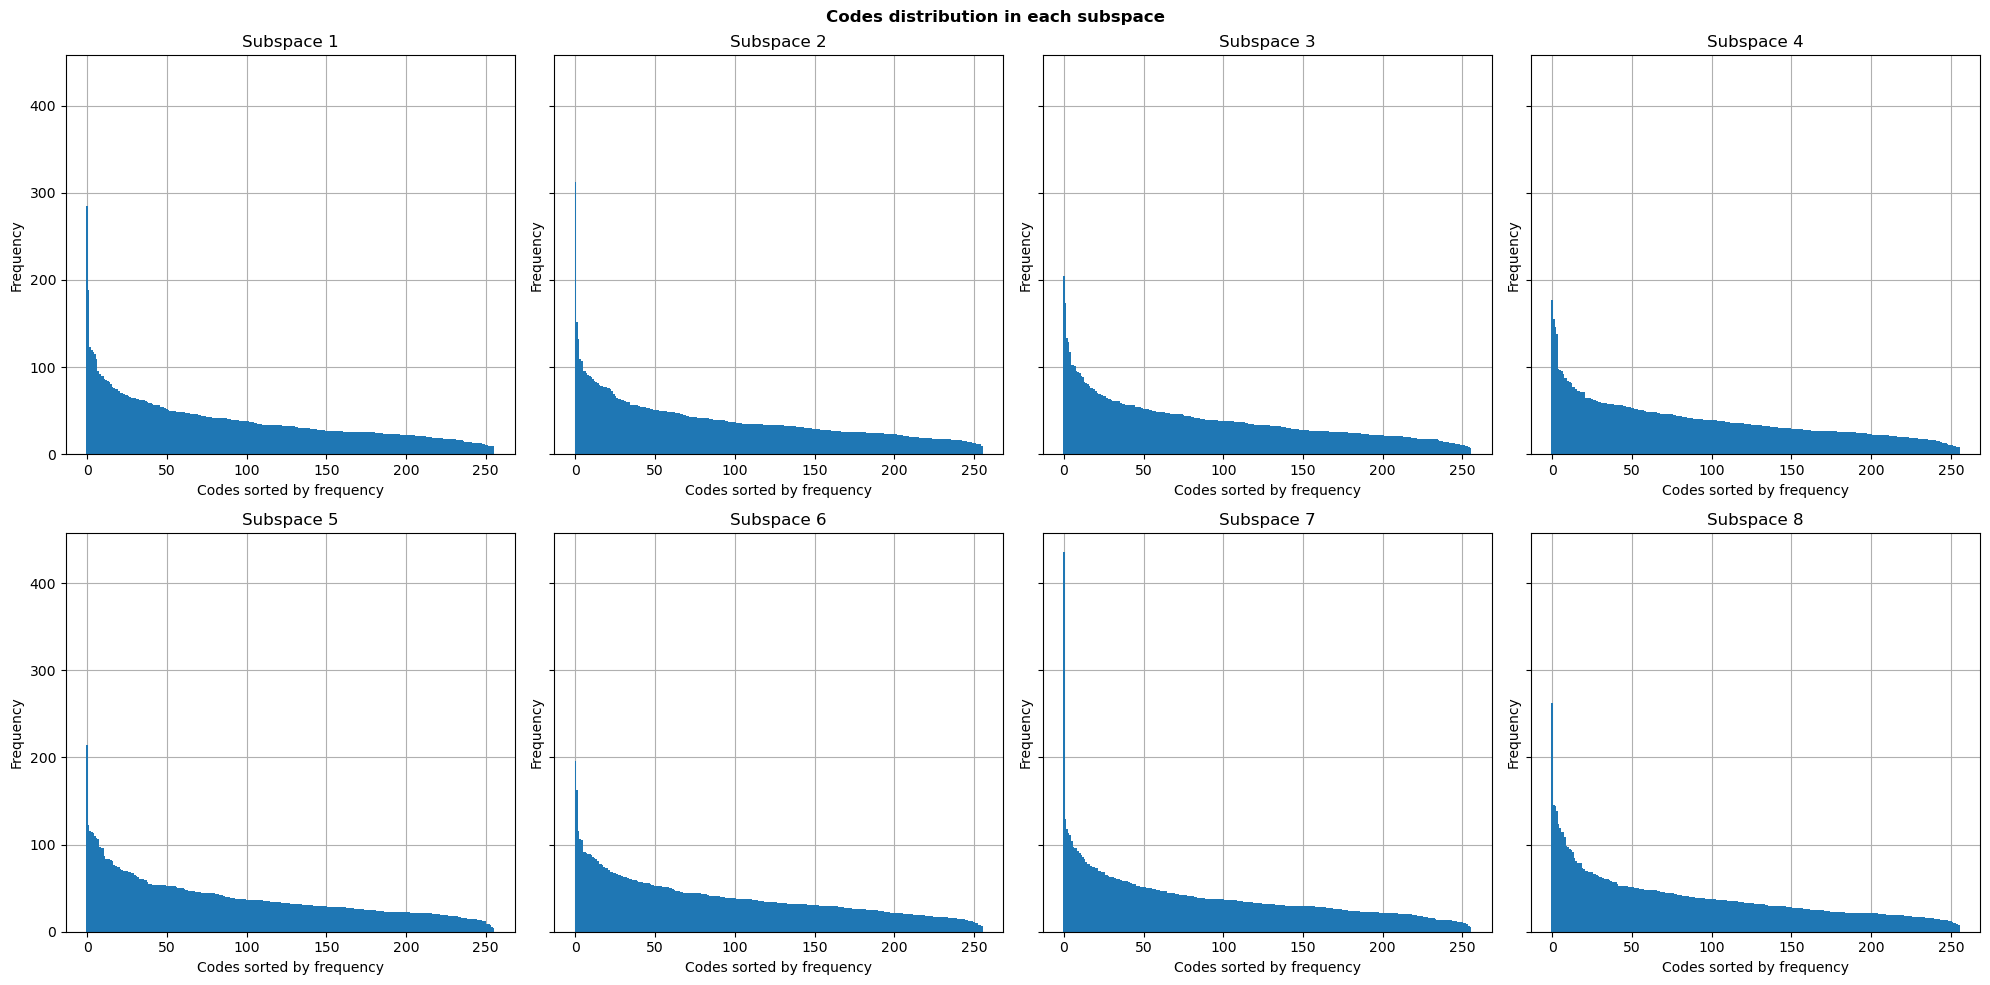

In [10]:
nrows = 5 if DATASET == "glove" else 2
fig, axs = plt.subplots(nrows, 4, figsize=(20, 10), sharey=True)
id = 0
for m in range(pq.M):
    hist, bins = np.histogram(pq.pqcode[:, m], bins=range(pq.K+1))
    hist = sorted(hist, reverse=True)
    axs[int(id/4)][id%4].bar(bins[:-1], hist, width=1)
    axs[int(id/4)][id%4].set_title(f"Subspace {m+1}")
    axs[int(id/4)][id%4].set_xlabel("Codes sorted by frequency")
    axs[int(id/4)][id%4].set_ylabel("Frequency")
    axs[int(id/4)][id%4].grid()
    axs[int(id/4)][id%4].set_axisbelow(True)
    id += 1
plt.suptitle("Codes distribution in each subspace", fontweight="bold")
plt.tight_layout()
plt.show()

Computing the exact distances for a sample query and checking if they are equal to the given ground truth distances:

In [11]:
es = ExactSearch(search_data)
exact_dists, exact_ranking = es.search(sample_query)
if DATASET != "glove":
    print(np.all(gt[0][:100]==exact_ranking[:100]))

True


Defining a function to plot exact vs approximate distances from a sample query for both symmetric and asymmetric approaches:

In [12]:
def plot_exact_vs_estimated(axs, exact_dists, asym_pq_dists, sym_pq_dists, query):
    query_snorm = np.sum(np.square(query))
    exact_dists = exact_dists / query_snorm
    asym_pq_dists = asym_pq_dists / query_snorm
    sym_pq_dists = sym_pq_dists / query_snorm
    
    xy_asym = np.vstack([exact_dists, asym_pq_dists])
    kernel_asym = gaussian_kde(xy_asym)(xy_asym)
    axs.scatter(
        exact_dists,
        asym_pq_dists,
        c=kernel_asym,
        cmap="Blues", edgecolor="black", label="ADC", zorder=2, marker="s")

    xy_sym = np.vstack([exact_dists, sym_pq_dists])
    kernel_sym = gaussian_kde(xy_sym)(xy_sym)
    axs.scatter(
        exact_dists,
        sym_pq_dists,
        c=kernel_sym,
        cmap="Reds", edgecolor="black", label="SDC", zorder=2, marker="o")

    axs.set_xlabel("Exact distances (normalized)")
    axs.set_ylabel("Estimated distances (normalized)")
    
    xpoints = axs.get_xlim()
    axs.plot(xpoints, xpoints, linestyle="--", color="black", zorder=1)
    
    axs.grid(zorder=0)
    axs.legend()

Computing the distances with PQ for a sample query and plotting their exact vs approximate values for a random subset of 200 database vectors:

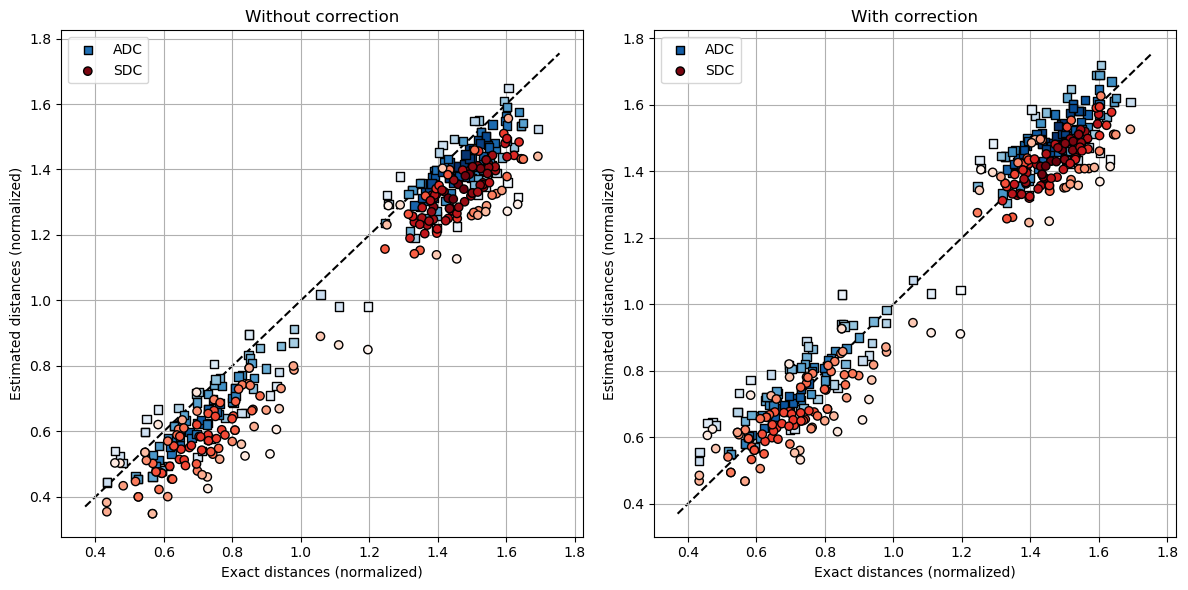

In [13]:
asym_pq_dists, asym_ranking = pq.search(sample_query, subset=None, asym=True, correct=False)
asym_pq_corr_dists, asym_corr_ranking = pq.search(sample_query, subset=None, asym=True, correct=True)
sym_pq_dists, sym_ranking = pq.search(sample_query, subset=None, asym=False, correct=False)
sym_pq_corr_dists, sym_corr_ranking = pq.search(sample_query, subset=None, asym=False, correct=True)

sample = np.random.randint(0, 1000, 200)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_exact_vs_estimated(axs[0], exact_dists[sample], asym_pq_dists[sample], sym_pq_dists[sample], sample_query)
axs[0].set_title("Without correction")
plot_exact_vs_estimated(axs[1], exact_dists[sample], asym_pq_corr_dists[sample], sym_pq_corr_dists[sample], sample_query)
axs[1].set_title("With correction");
plt.tight_layout()

Computing the differences between approximate and exact distances for all queries:

In [14]:
asym_diffs = np.zeros((search_data.shape[0] * queries.shape[0]))
asym_diffs_corr = np.zeros((search_data.shape[0] * queries.shape[0]))
sym_diffs = np.zeros((search_data.shape[0] * queries.shape[0]))
sym_diffs_corr = np.zeros((search_data.shape[0] * queries.shape[0]))

exact_ranks = np.empty((queries.shape[0], search_data.shape[0]))
mean_es_time = 0

for i, query in enumerate(queries):
    asym_d_est, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    asym_d_est_corr, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
    sym_d_est, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
    sym_d_est_corr, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)

    start_search_time = time.time()
    d, rank = es.search(query)
    mean_es_time += time.time() - start_search_time
    exact_ranks[i] = rank

    query_norm = np.sum(np.square(query))
    asym_diffs[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (asym_d_est-d) / query_norm
    asym_diffs_corr[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (asym_d_est_corr-d) / query_norm
    sym_diffs[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (sym_d_est-d) / query_norm
    sym_diffs_corr[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (sym_d_est_corr-d) / query_norm

mean_es_time /= queries.shape[0]

Plotting the distribution of the computed differences:

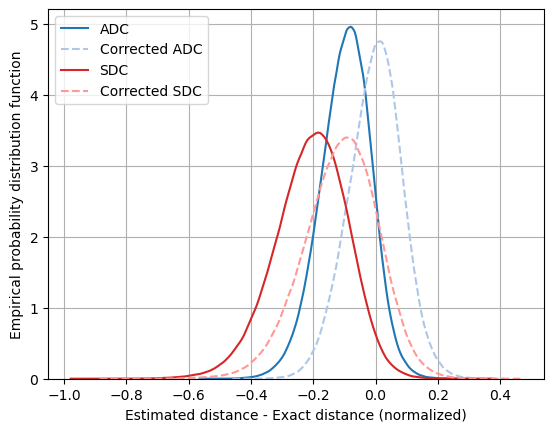

In [15]:
sns.kdeplot(asym_diffs, label="ADC", color=tab20(0))
sns.kdeplot(asym_diffs_corr, label="Corrected ADC", color=tab20(1), linestyle='dashed')
sns.kdeplot(sym_diffs, label="SDC", color=tab20(6))
sns.kdeplot(sym_diffs_corr, label="Corrected SDC", color=tab20(7), linestyle='dashed')
plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend();
plt.grid()

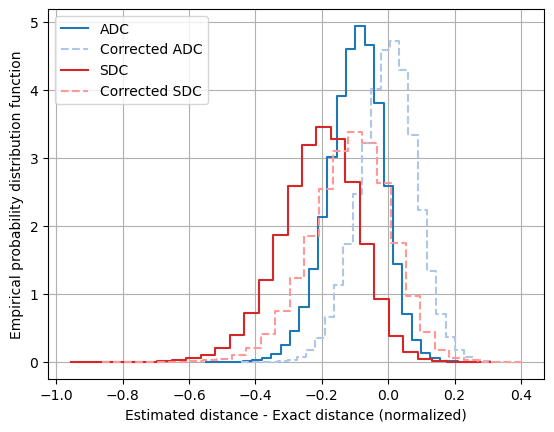

In [16]:
bins = 30

hist_asym, bin_edges_asym = np.histogram(asym_diffs, bins=bins, density=True)
plt.step(bin_edges_asym[:-1], hist_asym, where='post', label="ADC", color=tab20(0))

hist_asym_corr, bin_edges_asym_corr = np.histogram(asym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_asym_corr[:-1], hist_asym_corr, where='post', label="Corrected ADC", color=tab20(1), linestyle='dashed')

hist_sym, bin_edges_sym = np.histogram(sym_diffs, bins=bins, density=True)
plt.step(bin_edges_sym[:-1], hist_sym, where='post', label="SDC", color=tab20(6))

hist_sym_corr, bin_edges_sym_corr = np.histogram(sym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_sym_corr[:-1], hist_sym_corr, where='post', label="Corrected SDC", color=tab20(7), linestyle='dashed')

plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend()
plt.grid()

Computing the variance of the differences:

In [17]:
asym_diff_var = np.var(asym_diffs)
asym_corr_diff_var = np.var(asym_diffs_corr)
sym_diff_var = np.var(sym_diffs)
sym_corr_diff_var = np.var(sym_diffs_corr)
pd.DataFrame({
    "ADC": [asym_diff_var],
    "Corrected ADC": [asym_corr_diff_var],
    "SDC": [sym_diff_var],
    "Corrected SDC": [sym_corr_diff_var],
    }, index=["Variance of error"]).T.style.background_gradient(cmap='Blues')

Defining a function to compute the average recall at various values of `R` for a set of queries:

In [18]:
def compute_recall(index, R, queries, exact_ranks, w=4, correct=True, sym=True):
    """
    Compute average recall at all values in R for the given index and queries.

    Parameters
    ----------

    index : PQ or IVF
        The index to use for the search.
    
    R : list
        The list of values for which to compute the recall at.

    queries : np.ndarray
        The queries to use for the search.

    exact_ranks : np.ndarray
        The exact ranking of the search data for each query.

    w : int
        The number of centroids to visit in the IVF index.

    correct : bool
        Whether to compute also the corrected distances.

    sym : bool
        Whether to compute also the symmetric distances.

    Returns
    -------

    results : dict
        A dictionary containing the mean recall at each value of R for the
        asymmetric and symmetric distances, with and without correction.
        Recall is computed both as the number of relevant items in the top R,
        and as the presence of the nearest item in the top R (nearest recall).
    
    """

    asym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_asym_recall = np.full((len(queries), len(R)), np.nan)
    asym_corr_recall = np.full((len(queries), len(R)), np.nan)  
    nearest_asym_corr_recall = np.full((len(queries), len(R)), np.nan)
    sym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_sym_recall = np.full((len(queries), len(R)), np.nan)
    sym_corr_recall = np.full((len(queries), len(R)), np.nan)
    nearest_sym_corr_recall = np.full((len(queries), len(R)), np.nan)

    for i, query in enumerate(queries):
        if type(index) == PQ:
            _, asym_rank = index.search(query, subset=None, asym=True, correct=False)
            if correct:
                _, asym_corr_rank = index.search(query, subset=None, asym=True, correct=True)
            if sym:
                _, sym_rank = index.search(query, subset=None, asym=False, correct=False)
                if correct:
                    _, sym_corr_rank = index.search(query, subset=None, asym=False, correct=True)
        else:
            _, asym_rank = index.search(query, w=w, asym=True, correct=False)
            if correct:
                _, asym_corr_rank = index.search(query, w=w, asym=True, correct=True)
            if sym:
                _, sym_rank = index.search(query, w=w, asym=False, correct=False)
                if correct:
                    _, sym_corr_rank = index.search(query, w=w, asym=False, correct=True)

        for j, r in enumerate(R):
            if r <= len(asym_rank):
                asym_recall[i][j] = recall_at_r(asym_rank, exact_ranks[i], r)
                nearest_asym_recall[i][j] = exact_ranks[i][0] in asym_rank[:r]
            if correct and r <= len(asym_corr_rank):
                asym_corr_recall[i][j] = recall_at_r(asym_corr_rank, exact_ranks[i], r)
                nearest_asym_corr_recall[i][j] = exact_ranks[i][0] in asym_corr_rank[:r]
            if sym:
                if r <= len(sym_rank):
                    sym_recall[i][j] = recall_at_r(sym_rank, exact_ranks[i], r)
                    nearest_sym_recall[i][j] = exact_ranks[i][0] in sym_rank[:r]
                if correct and r <= len(sym_corr_rank):
                    sym_corr_recall[i][j] = recall_at_r(sym_corr_rank, exact_ranks[i], r)
                    nearest_sym_corr_recall[i][j] = exact_ranks[i][0] in sym_corr_rank[:r]

    # Catch the warning risen when the number of retrieved items for all the
    # queries is smaller than some value of R
    with warnings.catch_warnings(record=True) as w:
        asym_recall_mean = np.nanmean(asym_recall, axis=0)
        nearest_asym_recall_mean = np.nanmean(nearest_asym_recall, axis=0)
        asym_corr_recall_mean = np.nanmean(asym_corr_recall, axis=0)
        nearest_asym_corr_recall_mean = np.nanmean(nearest_asym_corr_recall, axis=0)
        sym_recall_mean = np.nanmean(sym_recall, axis=0)
        nearest_sym_recall_mean = np.nanmean(nearest_sym_recall, axis=0)
        sym_corr_recall_mean = np.nanmean(sym_corr_recall, axis=0)
        nearest_sym_corr_recall_mean = np.nanmean(nearest_sym_corr_recall, axis=0)
        if w:
            for warning in w:
                if "Mean of empty slice" not in str(warning.message):
                    warnings.warn(warning.message, warning.category)

    results = {
        "asym_recall_mean": asym_recall_mean,
        "nearest_asym_recall_mean": nearest_asym_recall_mean,
        "asym_corr_recall_mean": asym_corr_recall_mean,
        "nearest_asym_corr_recall_mean": nearest_asym_corr_recall_mean,
        "sym_recall_mean": sym_recall_mean,
        "nearest_sym_recall_mean": nearest_sym_recall_mean,
        "sym_corr_recall_mean": sym_corr_recall_mean,
        "nearest_sym_corr_recall_mean": nearest_sym_corr_recall_mean,
        "inertia": index.inertia
    }

    return results

Computing the average recall at various values of `R` for the set of queries and plotting the results:

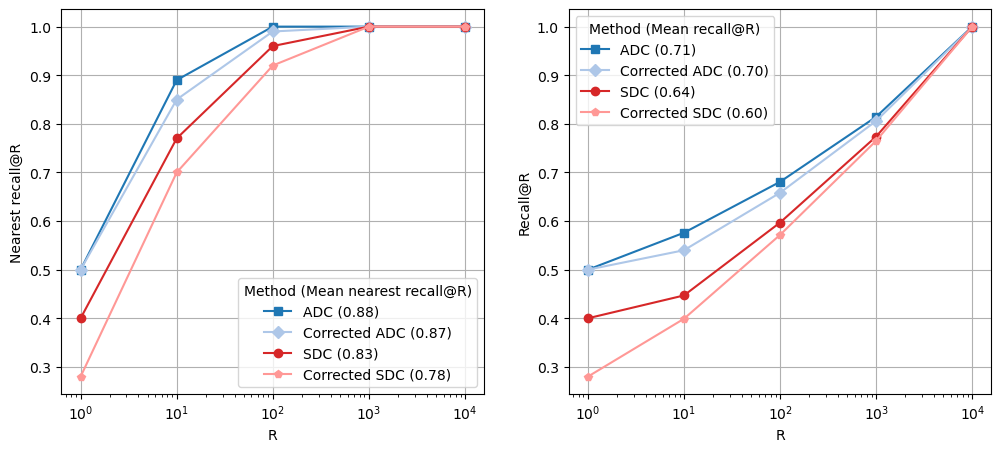

In [19]:
R = [1, 10, 100, 1000, 10000]
if DATASET == "sift":
    R += [100000, 1000000]

results_pq = compute_recall(pq, R, queries, exact_ranks)
results_pq["search_NMSE"] = NMSE(search_data, pq.decompress(pq.pqcode))
del pq

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-s', label=f"ADC ({np.mean(results_pq['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_pq["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected ADC ({np.mean(results_pq['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[0].plot(R, results_pq["nearest_sym_recall_mean"], '-o', label=f"SDC ({np.mean(results_pq['nearest_sym_recall_mean']):.2f})", color=tab20(6))
axs[0].plot(R, results_pq["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected SDC ({np.mean(results_pq['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

axs[1].plot(R, results_pq["asym_recall_mean"], '-s', label=f"ADC ({np.mean(results_pq['asym_recall_mean']):.2f})", color=tab20(0))
axs[1].plot(R, results_pq["asym_corr_recall_mean"], '-D', label=f"Corrected ADC ({np.mean(results_pq['asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[1].plot(R, results_pq["sym_recall_mean"], '-o', label=f"SDC ({np.mean(results_pq['sym_recall_mean']):.2f})", color=tab20(6))
axs[1].plot(R, results_pq["sym_corr_recall_mean"], '-p', label=f"Corrected SDC ({np.mean(results_pq['sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title="Method (Mean recall@R)")
axs[1].grid()

Computing the average recall at 100 for the set of queries with different values of `M` and `K`:

In [20]:
Ms = [1, 2, 4, 10, 20] if DATASET == "glove" else [1, 2, 4, 8, 16]
Ks = [16, 64, 256, 1024]

training_results = []
search_results = []

for m in Ms:
    for k in Ks:
        print(f"Training PQ with M={m}, K={k}...")
        
        pq = PQ(M=m, K=k, seed=RANDOM_SEED)
        start_training = time.time()
        pq.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        pq.add(search_data)
        adding_time = time.time() - start_adding
        
        decompressed_search = pq.decompress(pq.pqcode) 
        search_NMSE = NMSE(search_data, decompressed_search)
        compressed_tr = pq.compress(tr_data)
        decompressed_tr = pq.decompress(compressed_tr)
        tr_NMSE = NMSE(tr_data, decompressed_tr)

        code_length = int(np.log2(k)) * m
        curr_training_res = {
            "M": m, "K": k, "Code length [bits]": code_length,
            "Training time [s]": training_time, "Adding time [s]": adding_time,
            "TR NMSE": tr_NMSE,
            "SEARCH NMSE": search_NMSE
        } # TODO: utilizzo tutto di ciò che calcolo
        training_results.append(curr_training_res)
        
        for asym in [True, False]:
            mean_search_time = 0
            nearest_recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = pq.search(query, subset=None, asym=asym, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_ranks[i][0] in ranking[:100]:
                    nearest_recall_tr += 1
            mean_search_time /= queries.shape[0]
            nearest_recall_tr /= queries.shape[0]
            
            curr_search_res = {
                "M": m, "K": k, "Code length [bits]": code_length,
                "Asymmetric Distance": asym,
                "Mean search time [ms]": mean_search_time*1000,
                "Nearest recall@100": nearest_recall_tr
            }
            search_results.append(curr_search_res)

del pq
training_results = pd.DataFrame(training_results)
search_results = pd.DataFrame(search_results)

Training PQ with M=1, K=16...
Training PQ with M=1, K=64...
Training PQ with M=1, K=256...
Training PQ with M=1, K=1024...
Training PQ with M=2, K=16...
Training PQ with M=2, K=64...
Training PQ with M=2, K=256...
Training PQ with M=2, K=1024...
Training PQ with M=4, K=16...
Training PQ with M=4, K=64...
Training PQ with M=4, K=256...
Training PQ with M=4, K=1024...
Training PQ with M=8, K=16...
Training PQ with M=8, K=64...
Training PQ with M=8, K=256...
Training PQ with M=8, K=1024...
Training PQ with M=16, K=16...
Training PQ with M=16, K=64...
Training PQ with M=16, K=256...
Training PQ with M=16, K=1024...


Displaying the results about the training:

In [21]:
training_results.style.background_gradient(
    subset=["Training time [s]", "Adding time [s]", "TR NMSE", "SEARCH NMSE"],
    cmap='Blues'
)

Plotting the reconstruction error:

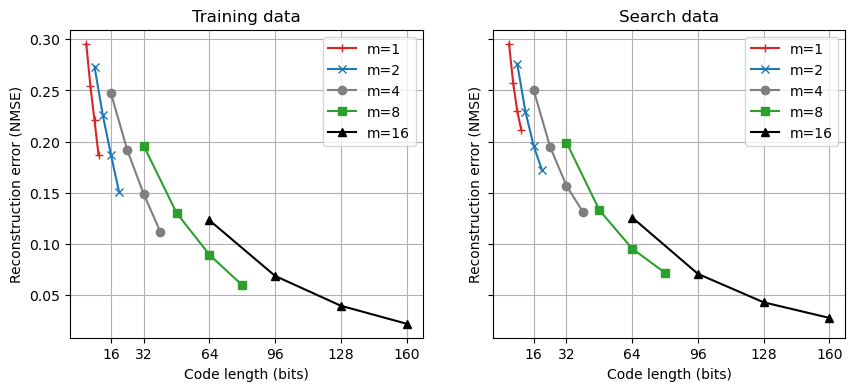

In [22]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
markers = ['+', 'x', 'o', 's', '^', 'D']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, m in enumerate(Ms):
    res = training_results[training_results["M"]==m]
    axs[0].plot(res["Code length [bits]"], res["TR NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")
    axs[1].plot(res["Code length [bits]"], res["SEARCH NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")

if DATASET != "glove":
    axs[0].set_xticks([16, 32, 64, 96, 128, 160])
    axs[1].set_xticks([16, 32, 64, 96, 128, 160])

axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Reconstruction error (NMSE)")
axs[0].set_title("Training data")
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Reconstruction error (NMSE)")
axs[1].set_title("Search data")
axs[1].legend()
axs[1].grid()

Displaying the results about the search:

In [23]:
print(f"Mean Exact Search time: {mean_es_time*1000} [ms]")
search_results.style.background_gradient(
    subset=["Mean search time [ms]", "Nearest recall@100"],
    cmap='Blues'
)

Mean Exact Search time: 1.2635350227355957 [ms]


Plotting the average recall at 100:

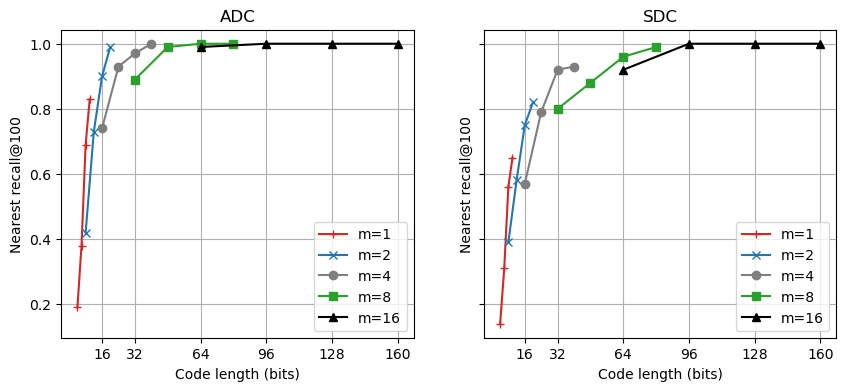

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Nearest recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Nearest recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")

if DATASET != "glove":
    axs[0].set_xticks([16, 32, 64, 96, 128, 160])
    axs[1].set_xticks([16, 32, 64, 96, 128, 160])

axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Nearest recall@100")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Nearest recall@100")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

Plotting the search time:

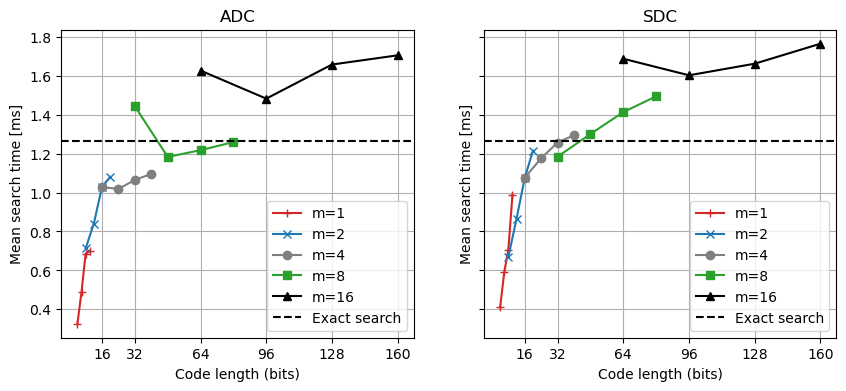

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
axs[1].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

if DATASET != "glove":
    axs[0].set_xticks([16, 32, 64, 96, 128, 160])
    axs[1].set_xticks([16, 32, 64, 96, 128, 160])

axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Mean search time [ms]")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Mean search time [ms]")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

SIFT descriptors are constructed as concatenated orientation histograms. Each histogram is calculated within grid cells of an image patch, as illustrated in the figure below (sourced from "Computer Vision Metrics - Survey, Taxonomy, and Analysis", by Scott Krigg).

<img src="./img/sift.png" alt="My Image" width="500"/>

Using a product quantizer, histogram bins may be assigned to different quantization groups. The "natural" order groups consecutive components, while the "structured" order clusters related dimensions—for example, grouping 2x2 patches when `M`=4. To assess the impact of these grouping strategies, we also compare them to a "random" order.

In [26]:
if DATASET != "glove":
    # Prepare data for the structured permutation
    struct_perm = list(range(0, 16)) + list(range(32, 48)) + \
        list(range(16, 32)) + list(range(48, 64)) + \
        list(range(64, 80)) + list(range(96, 112)) + \
        list(range(80, 96)) + list(range(112, 128))
    tr_data_struct = tr_data[:, struct_perm]
    queries_struct = queries[:, struct_perm]
    search_data_struct = search_data[:, struct_perm]

    # Compute recall for the structured permutation when training and searching
    # on different data
    pq_struct = PQ(M=4, K=K, seed=RANDOM_SEED)
    print("Training PQ with structured permutation on training data...")
    pq_struct.train(tr_data_struct, add=False)
    pq_struct.add(search_data_struct)
    results_struct_disj = compute_recall(
        index=pq_struct, R=[10], queries=queries_struct,
        exact_ranks=exact_ranks, correct=False,
        sym=False
    )
    recall_struct_perm_disj = results_struct_disj["nearest_asym_recall_mean"][0]
    del pq_struct

    # Compute recall for the natural permutation when training and searching
    # on different data
    pq = PQ(M=4, K=K, seed=RANDOM_SEED)
    print("Training PQ with natural permutation on training data...")
    pq.train(tr_data, add=False)
    pq.add(search_data)
    results_disj = compute_recall(
        index=pq, R=[10], queries=queries,
        exact_ranks=exact_ranks, correct=False,
        sym=False
    )
    recall_disj = results_disj["nearest_asym_recall_mean"][0]
    del pq

    recalls_rand_disj = []
    for rep in range(0, 5):
        # Prepare data for the random permutation
        rand_perm = np.random.permutation(128)
        tr_data_rand = tr_data[:, rand_perm]
        queries_rand = queries[:, rand_perm]
        search_data_rand = search_data[:, rand_perm]

        # Compute recall for the random permutation when training and searching
        # on different data
        pq_rand = PQ(M=4, K=K, seed=RANDOM_SEED)
        print(f"[{rep+1}/5] Training PQ with random permutation on training data...")
        pq_rand.train(tr_data_rand, add=False)
        pq_rand.add(search_data_rand)
        results_rand_disj = compute_recall(
            index=pq_rand, R=[10], queries=queries_rand,
            exact_ranks=exact_ranks, correct=False,
            sym=False
        )
        recall_rand_disj = results_rand_disj["nearest_asym_recall_mean"][0]
        recalls_rand_disj.append(recall_rand_disj)

    del pq_rand
    recall_rand_mean_disj = np.mean(recalls_rand_disj)
    recall_rand_std_disj = np.std(recalls_rand_disj)

    # Compute recall for the structured permutation when training and searching
    # on the same data
    pq_struct = PQ(M=4, K=K, seed=RANDOM_SEED)
    print("Training PQ with structured permutation on search data...")
    pq_struct.train(search_data_struct, add=True)
    results_perm = compute_recall(
        index=pq_struct, R=[10], queries=queries_struct,
        exact_ranks=exact_ranks, correct=False, sym=False
    )
    recall_struct = results_perm["nearest_asym_recall_mean"][0]

    # Compute recall for the natural permutation when training and searching
    # on the same data
    print("Training PQ with natural permutation on search data...")
    pq = PQ(M=4, K=K, seed=RANDOM_SEED)
    pq.train(search_data, add=True)
    results_search = compute_recall(
        index=pq, R=[10], queries=queries,
        exact_ranks=exact_ranks, correct=False, sym=False
    )
    recall_search = results_search["nearest_asym_recall_mean"][0]

    recalls_rand = []
    for rep in range(0, 5):
        # Prepare data for the random permutation
        rand_perm = np.random.permutation(128)
        tr_data_rand = tr_data[:, rand_perm]
        queries_rand = queries[:, rand_perm]
        search_data_rand = search_data[:, rand_perm]
        
        # Compute recall for the random permutation when training and searching
        # on the same data
        print(f"[{rep+1}/5] Training PQ with random permutation on search data...")
        pq_rand = PQ(M=4, K=K, seed=RANDOM_SEED)
        pq_rand.train(search_data_rand, add=True)
        results_random = compute_recall(
            index=pq_rand, R=[10], queries=queries_rand,
            exact_ranks=exact_ranks, correct=False, sym=False
        )
        recall_rand = results_random["nearest_asym_recall_mean"][0]
        recalls_rand.append(recall_rand)

    del pq_rand
    recall_rand_mean = np.mean(recalls_rand)
    recall_rand_std = np.std(recalls_rand)

    display(pd.DataFrame({
        "natural": [nearest_recall_tr, recall_search],
        "structured": [recall_struct_perm_disj, recall_struct],
        "random mean": [recall_rand_mean_disj, recall_rand_mean],
        "random std": [recall_rand_std_disj, recall_rand_std]
    }, index=[
        "nearest recall@10 (training data)",
        "nearest recall@10 (search data)"
        ]
    ).style.background_gradient(cmap='Blues', axis=1))

Training PQ with structured permutation on training data...
Training PQ with natural permutation on training data...
[1/5] Training PQ with random permutation on training data...
[2/5] Training PQ with random permutation on training data...
[3/5] Training PQ with random permutation on training data...
[4/5] Training PQ with random permutation on training data...
[5/5] Training PQ with random permutation on training data...
Training PQ with structured permutation on search data...
Training PQ with natural permutation on search data...
[1/5] Training PQ with random permutation on search data...
[2/5] Training PQ with random permutation on search data...
[3/5] Training PQ with random permutation on search data...
[4/5] Training PQ with random permutation on search data...
[5/5] Training PQ with random permutation on search data...


Evaluating the impact of KMeans initialization on the search performance:

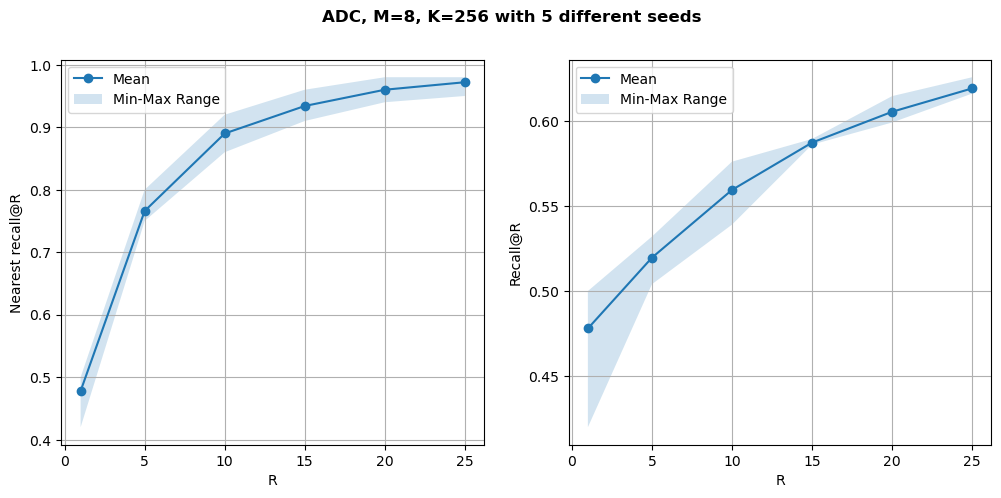

In [27]:
def compute_PQ_recall(M, K, seed, R, tr_data, search_data, queries, exact_ranks):
    pq = PQ(M=M, K=K, seed=seed)
    pq.train(tr_data, add=False)
    pq.add(search_data, compute_distortions=False)
    results = compute_recall(pq, R, queries, exact_ranks, correct=False, sym=False)
    return results

R_small = [1, 5, 10, 15, 20, 25]

results_pq_seeds = []
for i in range(5):
    results = compute_PQ_recall(M, K, RANDOM_SEED+i, R_small, tr_data, search_data, queries, exact_ranks)
    results_pq_seeds.append(results)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

nearest_asym_recall_means_seeds = np.array([results["nearest_asym_recall_mean"] for results in results_pq_seeds])
mean_nearest_seeds = nearest_asym_recall_means_seeds.mean(axis=0)
min_nearest_seeds = nearest_asym_recall_means_seeds.min(axis=0)
max_nearest_seeds = nearest_asym_recall_means_seeds.max(axis=0)

axs[0].plot(R_small, mean_nearest_seeds, marker='o', label='Mean')
axs[0].fill_between(R_small, min_nearest_seeds, max_nearest_seeds, alpha=0.2, label='Min-Max Range')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].grid()
axs[0].legend()

asym_recall_means_seeds = np.array([results["asym_recall_mean"] for results in results_pq_seeds])
mean_asym_seeds = asym_recall_means_seeds.mean(axis=0)
min_asym_seeds = asym_recall_means_seeds.min(axis=0)
max_asym_seeds = asym_recall_means_seeds.max(axis=0)

axs[1].plot(R_small, mean_asym_seeds, marker='o', label='Mean')
axs[1].fill_between(R_small, min_asym_seeds, max_asym_seeds, alpha=0.2, label='Min-Max Range')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].grid()
axs[1].legend()

fig.suptitle(f"ADC, M={M}, K={K} with 5 different seeds", fontweight='bold')
plt.show()

In [28]:
stds = np.std([results["nearest_asym_recall_mean"] for results in results_pq_seeds], axis=0)
seeds_res_df = pd.DataFrame(stds, index=R_small, columns=["Standard deviation of nearest recall @ R"])
seeds_res_df.index.name = "R"
seeds_res_df.style.background_gradient(cmap='Blues')

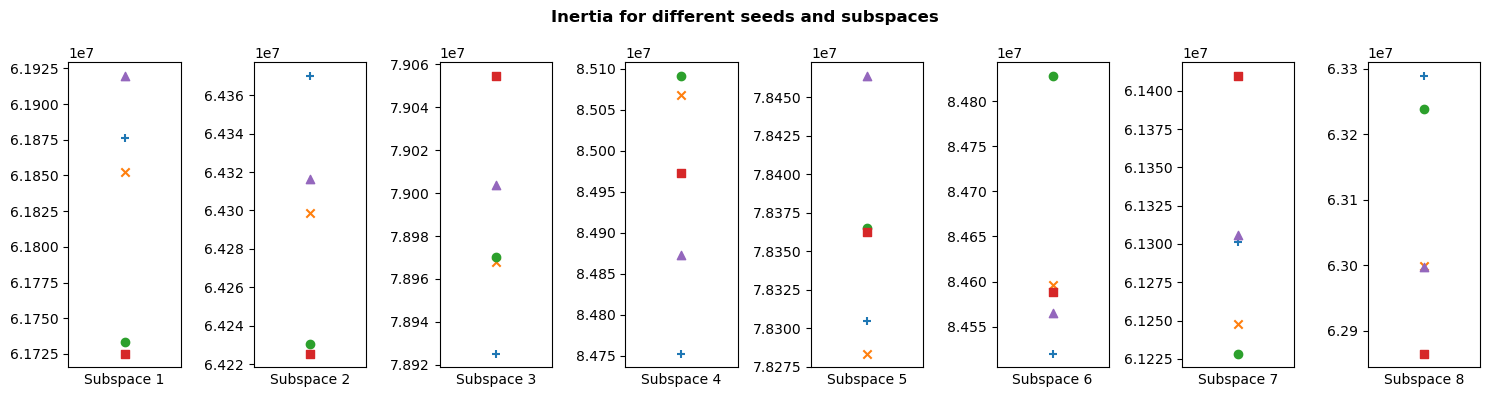

In [29]:
fig, axs = plt.subplots(1, M, figsize=(15, 4))

for i in range(M):
    for j, results in enumerate(results_pq_seeds):
        axs[i].scatter(i, results["inertia"][i], color=tab10(j), marker=markers[j])
        axs[i].set_xticks([])
        axs[i].set_xlabel(f"Subspace {i+1}")

fig.suptitle("Inertia for different seeds and subspaces", fontweight='bold')
fig.tight_layout()

### Product Quantization with InVerted File index (IVF)

Training the PQ quantizer with IVF:

In [30]:
KP = 2014 if DATASET == "sift" else 128
W = 20 if DATASET == "glove" else 8

ivf = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
start_training_ivf = time.time()
ivf.train(tr_data, add=False)
training_ivf = time.time() - start_training_ivf

start_adding_ivf = time.time()
ivf.add(search_data, compute_distortions=True)
adding_ivf = time.time() - start_adding_ivf

pd.DataFrame({
    "Training time [s]": training_ivf,
    "Adding time [s]": adding_ivf,
}, index=["With average distance computation"])

Training time [s]  Adding time [s]
With average distance computation           6.469233         0.207591

Visualizing the index lists lengths:

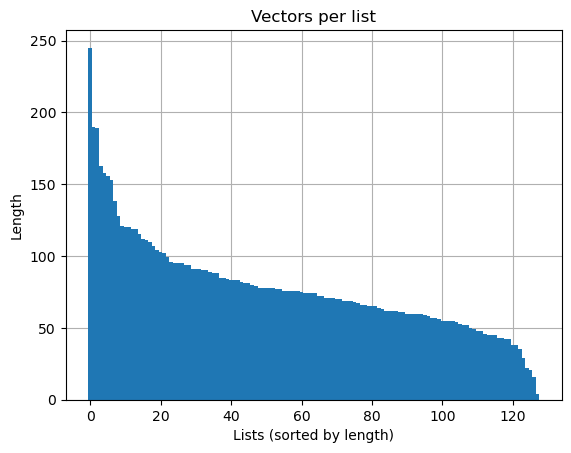

In [31]:
els_per_cluster = []
for i in range(ivf.Kp):
    els_per_cluster.append(len(ivf.ivf[i]))
fig, axs = plt.subplots(1)
axs.bar(range(ivf.Kp), sorted(els_per_cluster, reverse=True), width=1.0)
axs.set_xlabel("Lists (sorted by length)")
axs.set_ylabel("Length")
axs.set_title("Vectors per list")
axs.set_axisbelow(True)
axs.grid()

Computing the average recall at various values of `R` for the set of queries and plotting the results:

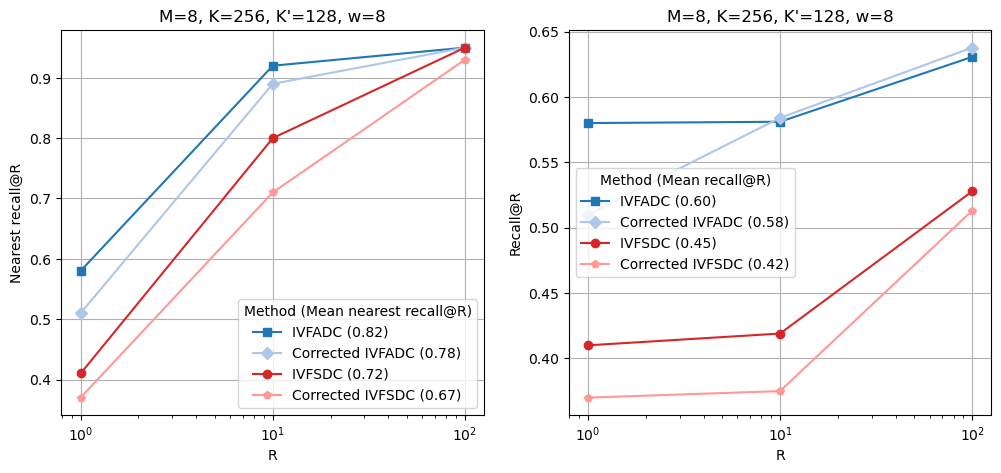

In [32]:
results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"IVFADC ({np.nanmean(results_ivf['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_ivf["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected IVFADC ({np.nanmean(results_ivf['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[0].plot(R, results_ivf["nearest_sym_recall_mean"], '-o', label=f"IVFSDC ({np.nanmean(results_ivf['nearest_sym_recall_mean']):.2f})", color=tab20(6))
axs[0].plot(R, results_ivf["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected IVFSDC ({np.nanmean(results_ivf['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].set_title(f"M={M}, K={K}, K'={KP}, w={W}")
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

axs[1].plot(R, results_ivf["asym_recall_mean"], '-s', label=f"IVFADC ({np.nanmean(results_ivf['asym_recall_mean']):.2f})", color=tab20(0))
axs[1].plot(R, results_ivf["asym_corr_recall_mean"], '-D', label=f"Corrected IVFADC ({np.nanmean(results_ivf['asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[1].plot(R, results_ivf["sym_recall_mean"], '-o', label=f"IVFSDC ({np.nanmean(results_ivf['sym_recall_mean']):.2f})", color=tab20(6))
axs[1].plot(R, results_ivf["sym_corr_recall_mean"], '-p', label=f"Corrected IVFSDC ({np.nanmean(results_ivf['sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].set_title(f"M={M}, K={K}, K'={KP}, w={W}")
axs[1].legend(title="Method (Mean recall@R)")
axs[1].grid()

Plotting the average recall at 100 of PQ with and without IVF:

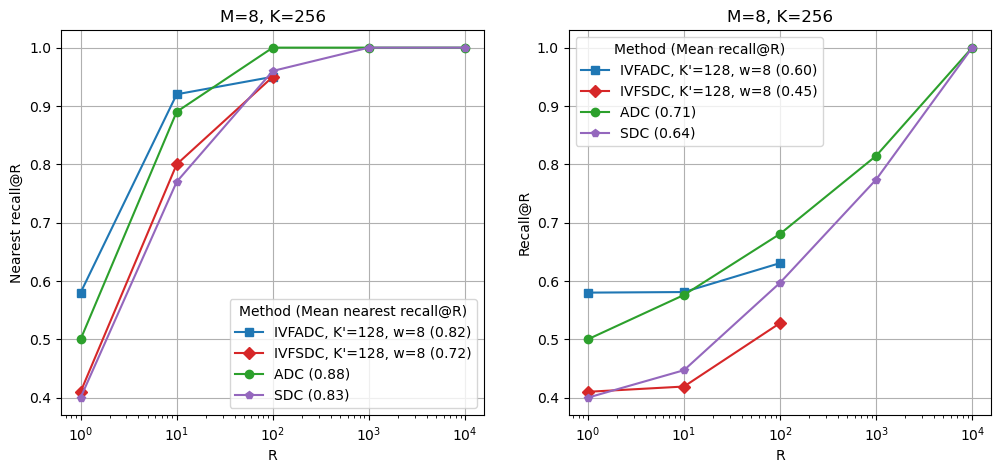

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"IVFADC, K'={KP}, w={W} ({np.nanmean(results_ivf['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_ivf["nearest_sym_recall_mean"], '-D', label=f"IVFSDC, K'={KP}, w={W} ({np.nanmean(results_ivf['nearest_sym_recall_mean']):.2f})", color=tab20(6))
axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-o', label=f"ADC ({np.nanmean(results_pq['nearest_asym_recall_mean']):.2f})", color=tab20(4))
axs[0].plot(R, results_pq["nearest_sym_recall_mean"], '-p', label=f"SDC ({np.nanmean(results_pq['nearest_sym_recall_mean']):.2f})", color=tab20(8))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].set_title(f"M={M}, K={K}")
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R, results_ivf["asym_recall_mean"], '-s', label=f"IVFADC, K'={KP}, w={W} ({np.nanmean(results_ivf['asym_recall_mean']):.2f})", color=tab20(0))
axs[1].plot(R, results_ivf["sym_recall_mean"], '-D', label=f"IVFSDC, K'={KP}, w={W} ({np.nanmean(results_ivf['sym_recall_mean']):.2f})", color=tab20(6))
axs[1].plot(R, results_pq["asym_recall_mean"], '-o', label=f"ADC ({np.nanmean(results_pq['asym_recall_mean']):.2f})", color=tab20(4))
axs[1].plot(R, results_pq["sym_recall_mean"], '-p', label=f"SDC ({np.nanmean(results_pq['sym_recall_mean']):.2f})", color=tab20(8))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].set_title(f"M={M}, K={K}")
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

Visualizing the average distances from the queries to the coarse centroids:

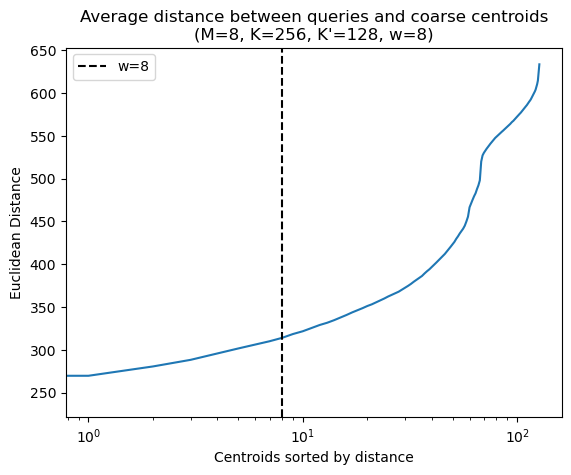

In [34]:
mean_dists2centroids = np.zeros(ivf.Kp)

for i, query in enumerate(queries):
    _, ivf_asym_rank = ivf.search(query, w=W, asym=True, correct=False)
    dist2centroids = cdist([query], ivf.centroids, 'euclidean')[0]
    sorted_dist2centroids = np.sort(dist2centroids)
    mean_dists2centroids += sorted_dist2centroids

mean_dists2centroids /= queries.shape[0]

plt.plot(mean_dists2centroids)
plt.xlabel("Centroids sorted by distance")
plt.ylabel("Euclidean Distance")
plt.axvline(x=W, color='k', linestyle='--', label=f"w={W}")
plt.xscale('log')
plt.legend()
plt.title(f"Average distance between queries and coarse centroids\n(M={M}, K={K}, K'={KP}, w={W})");

Computing the average recall at 100 for the set of queries with different values of `M`, `K'` and `w`:

In [35]:
K = 256
Ms = [1, 2, 4, 10, 20] if DATASET == "glove" else [1, 2, 4, 8, 16]
Kps = [1024, 8192] if DATASET == "sift" else [16, 128]
ws = [1, 8, 64] if DATASET == "sift" else [1, 2, 8]

ivf_training_results = []
ivf_search_results = []

for m in Ms:
    for Kp in Kps:
        print(f"Training IVF PQ with M={m}, K'={Kp}...")
        ivf = IVF(Kp=Kp, M=m, K=K, seed=RANDOM_SEED)
        start_training = time.time()
        ivf.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        ivf.add(search_data)
        adding_time = time.time() - start_adding

        code_length = int(np.log2(K)) * m
        curr_training_res = {
            "M": m, "K": K, "K'": Kp,
            "Code length [bits]": code_length,
            "Training time [s]": training_time,
            "Adding time [s]": adding_time
        }
        ivf_training_results.append(curr_training_res)
        
        for w in ws:
            if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
            mean_search_time = 0
            nearest_recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = ivf.search(query, w=w, asym=True, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_ranks[i][0] in ranking[:100]:
                    nearest_recall_tr += 1
            mean_search_time /= len(queries)
            nearest_recall_tr /= len(queries)
            
            curr_search_res = {
                "M": m, "K": K, "K'": Kp, "w": w,
                "Code length [bits]": code_length,
                "Mean search time [ms]": mean_search_time*1000,
                "Nearest recall@100": nearest_recall_tr
            } # TODO: utilizzo tutto di ciò che calcolo
            ivf_search_results.append(curr_search_res)

del ivf
ivf_training_results = pd.DataFrame(ivf_training_results)
ivf_search_results = pd.DataFrame(ivf_search_results)

Training IVF PQ with M=1, K'=16...
Training IVF PQ with M=1, K'=128...
Training IVF PQ with M=2, K'=16...
Training IVF PQ with M=2, K'=128...
Training IVF PQ with M=4, K'=16...
Training IVF PQ with M=4, K'=128...
Training IVF PQ with M=8, K'=16...
Training IVF PQ with M=8, K'=128...
Training IVF PQ with M=16, K'=16...
Training IVF PQ with M=16, K'=128...


Plotting the average recall at 100:

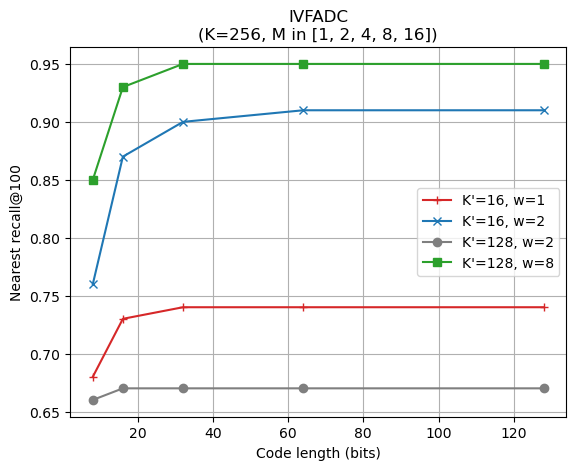

In [36]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["K'"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Nearest recall@100"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.xlabel("Code length (bits)")
plt.ylabel("Nearest recall@100")
plt.title(f"IVFADC\n(K={K}, M in {Ms})")
plt.legend()
plt.grid()

Plotting the search time:

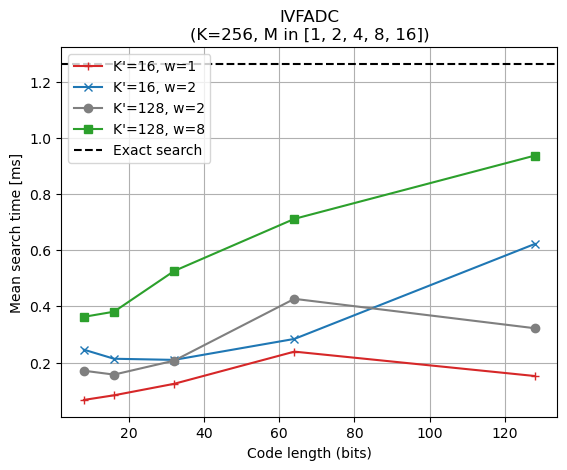

In [37]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["K'"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
plt.xlabel("Code length (bits)")
plt.ylabel("Mean search time [ms]")
plt.title(f"IVFADC\n(K={K}, M in {Ms})")
plt.legend()
plt.grid()

Comparing search times and average recall at 100 of PQ with and without IVF, for a code length of 64 bits:

In [38]:
search_results[(search_results["M"]==m) & (search_results["K"]==256)].style.background_gradient(
    subset=['Mean search time [ms]', 'Nearest recall@100'],
    cmap='Blues'
)

In [39]:
m = 8 if DATASET == "siftsmall" or DATASET == "sift" else 10
ivf_search_results[(ivf_search_results["M"]==m)].style.background_gradient(
    subset=['Mean search time [ms]', 'Nearest recall@100'],
    cmap='Blues'
)

## Exploration of alternative approaches

### Product Quantization without inverted file index

Computing the average recall at various values of `R` for the set of queries on scaled data with different scaling approaches and plotting the results as well as the KMeans inertia (sum of squared distances of samples to their closest cluster center) in each subspace:

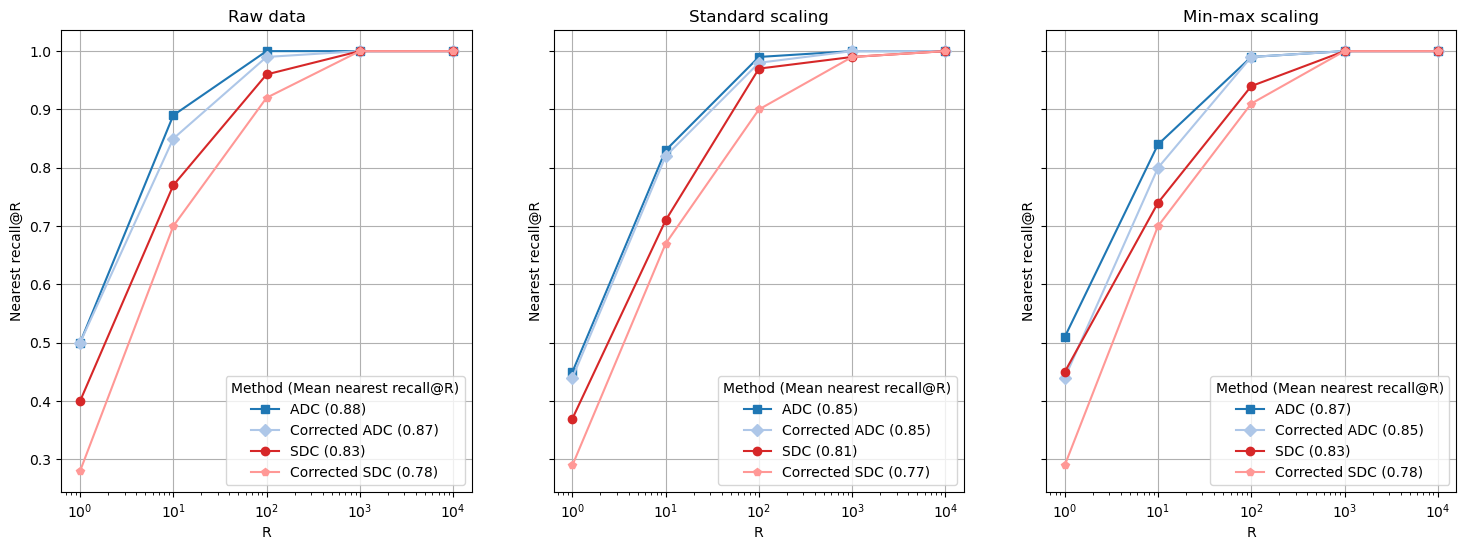

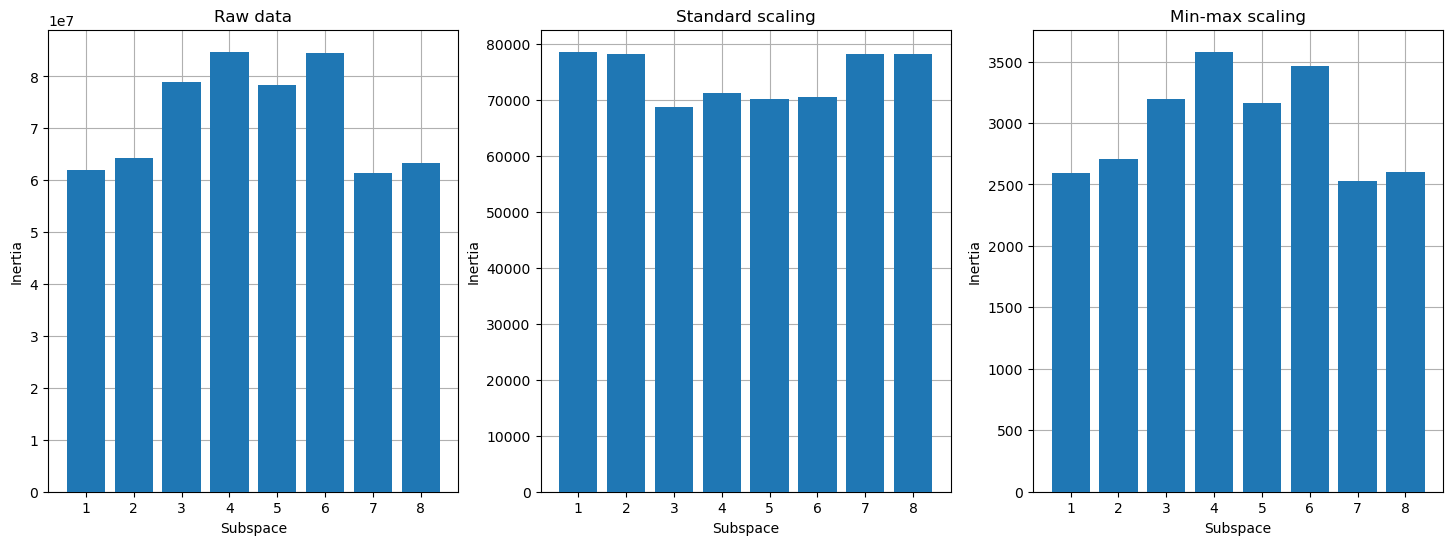

In [40]:
std_scaler = StandardScaler()
tr_data_std = std_scaler.fit_transform(tr_data)
search_data_std = std_scaler.transform(search_data)
queries_std = std_scaler.transform(queries)

pq_std = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_std.train(tr_data_std, add=False)
pq_std.add(search_data_std, compute_distortions=True)
results_pq_std = compute_recall(pq_std, R, queries_std, exact_ranks)
del pq_std

minmax_scaler = MinMaxScaler()
tr_data_minmax = minmax_scaler.fit_transform(tr_data)
search_data_minmax = minmax_scaler.transform(search_data)
queries_minmax = minmax_scaler.transform(queries)

pq_minmax = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_minmax.train(tr_data_minmax, add=False)
pq_minmax.add(search_data_minmax, compute_distortions=True)
results_pq_minmax = compute_recall(pq_minmax, R, queries_minmax, exact_ranks)
del pq_minmax

scaling_methods = [
    ("Raw data", results_pq),
    ("Standard scaling", results_pq_std),
    ("Min-max scaling", results_pq_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data) in zip(axs, scaling_methods):
    ax.plot(R, data["nearest_asym_recall_mean"], '-s', label=f"ADC ({np.mean(data['nearest_asym_recall_mean']):.2f})", color=tab20(0))
    ax.plot(R, data["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected ADC ({np.mean(data['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
    ax.plot(R, data["nearest_sym_recall_mean"], '-o', label=f"SDC ({np.mean(data['nearest_sym_recall_mean']):.2f})", color=tab20(6))
    ax.plot(R, data["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected SDC ({np.mean(data['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Nearest recall@R')
    ax.set_title(title)
    ax.legend(title="Method (Mean nearest recall@R)")
    ax.grid()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, (title, results) in zip(axs, scaling_methods):
    ax.bar(range(1, results["inertia"].shape[0]+1), results["inertia"], zorder=3)
    ax.set_xlabel('Subspace')
    ax.set_ylabel('Inertia')
    ax.set_title(title)
    ax.grid(zorder=0)
plt.show()

Plotting the variance explained by the PCA components in each subspace:

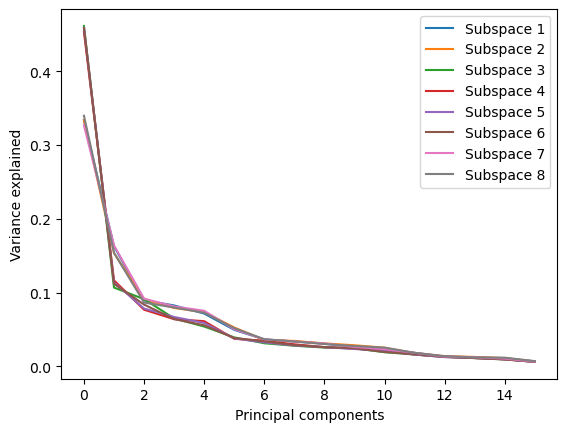

In [41]:
pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_pca.plot_variance_explained(tr_data)

Computing and plotting the average recall at various values of `R` for the set of queries on PCA-reduced data, using different numbers of components and the following approaches:
- Reducing the dimensionality of each subspace and storing centroids in the reduced space (labeled "Subspace Dim. Red." in the figure legend).
- Reducing the dimensionality of each subspace, computing centroids in the reduced space, and transforming them back to the original space (labeled "Centroids Dim. Red." in the figure legend).
- Reducing the dimensionality of entire vectors (not subspaces) before PQ training (labeled "Dim. Red." in the figure legend).

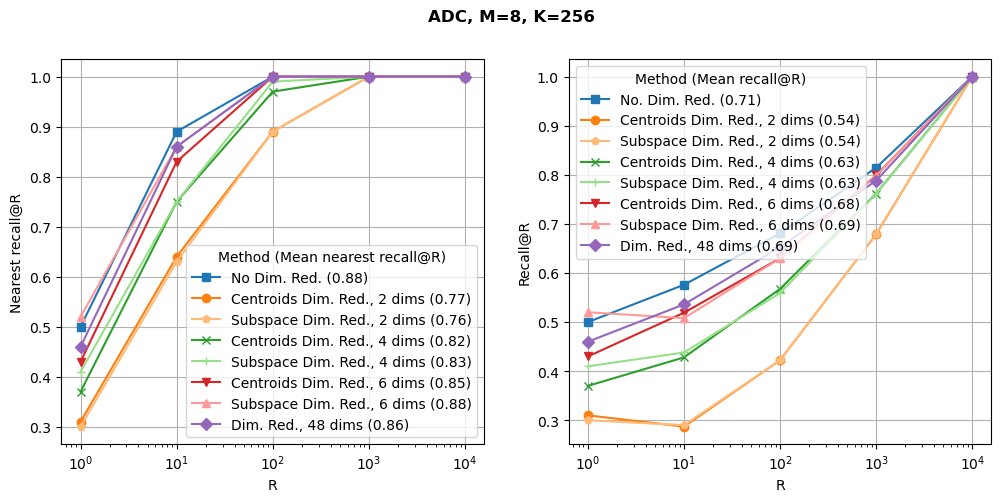

In [42]:
results_pca = {}
num_dims = [2, 4, 6]
for dim in num_dims:
    pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED, dim_reduction=True)
    pq_pca.train(tr_data, add=False, num_dims=dim)
    pq_pca.add(search_data, compute_distortions=False)
    results_pq_pca = compute_recall(pq_pca, R, queries, exact_ranks, correct=False, sym=False)
    results_pca[f"{dim}_red"] = results_pq_pca
    results_pca[f"{dim}_red"]["search_NMSE"] = NMSE(search_data, pq_pca.decompress(pq_pca.pqcode))

for dim in num_dims:
    pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED, dim_reduction=False)
    pq_pca.train(tr_data, add=False, num_dims=dim)
    pq_pca.add(search_data, compute_distortions=False)
    results_pq_pca = compute_recall(pq_pca, R, queries, exact_ranks, correct=False, sym=False)
    results_pca[dim] = results_pq_pca
    results_pca[dim]["search_NMSE"] = NMSE(search_data, pq_pca.decompress(pq_pca.pqcode))

n_components = 48 if DATASET == "siftsmall" or DATASET == "sift" else 40 # needs to be a multiple of M
pca = PCA(n_components=n_components).fit(tr_data)
tr_data_red = pca.transform(tr_data)
search_data_red = pca.transform(search_data)
queries_red = pca.transform(queries)
pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_pca.train(tr_data_red, add=False)
pq_pca.add(search_data_red, compute_distortions=False)
results_pq_pca = compute_recall(pq_pca, R, queries_red, exact_ranks, correct=False, sym=False)
results_pca["full_red"] = results_pq_pca

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-s', label=f"No Dim. Red. ({np.mean(results_pq['nearest_asym_recall_mean']):.2f})", color=tab20(0))
for i, dim, m1, m2 in zip(range(2, len(num_dims)*2+2, 2), num_dims, ['-o', '-x', '-v'], ['-p', '-+', '-^']):
    axs[0].plot(R, results_pca[dim]["nearest_asym_recall_mean"], m1, label=f"Centroids Dim. Red., {dim} dims ({np.mean(results_pca[dim]['nearest_asym_recall_mean']):.2f})", color=tab20(i))
    axs[0].plot(R, results_pca[f"{dim}_red"]["nearest_asym_recall_mean"], m2, label=f"Subspace Dim. Red., {dim} dims ({np.mean(results_pca[f'{dim}_red']['nearest_asym_recall_mean']):.2f})", color=tab20(i+1))
axs[0].plot(R, results_pca["full_red"]["nearest_asym_recall_mean"], '-D', label=f"Dim. Red., {n_components} dims ({np.mean(results_pca['full_red']['nearest_asym_recall_mean']):.2f})", color=tab20(len(num_dims)*2+2))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R, results_pq["asym_recall_mean"], '-s', label=f"No. Dim. Red. ({np.mean(results_pq['asym_recall_mean']):.2f})", color=tab20(0))
for i, dim, m1, m2 in zip(range(2, len(num_dims)*2+2, 2), num_dims, ['-o', '-x', '-v'], ['-p', '-+', '-^']):
    axs[1].plot(R, results_pca[dim]["asym_recall_mean"], m1, label=f"Centroids Dim. Red., {dim} dims ({np.mean(results_pca[dim]['asym_recall_mean']):.2f})", color=tab20(i))
    axs[1].plot(R, results_pca[f"{dim}_red"]["asym_recall_mean"], m2, label=f"Subspace Dim. Red., {dim} dims ({np.mean(results_pca[f'{dim}_red']['asym_recall_mean']):.2f})", color=tab20(i+1))
axs[1].plot(R, results_pca["full_red"]["asym_recall_mean"], '-D', label=f"Dim. Red., {n_components} dims ({np.mean(results_pca['full_red']['asym_recall_mean']):.2f})", color=tab20(len(num_dims)*2+2))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, M={M}, K={K}", fontweight='bold');

del pq_pca

Drop in recall is due to training-indexing mismatch (if trained on search data achieves a mean nearest recall@R of 0.83).

Displaying NMSE on search data:

In [43]:
pca_nmse = {}
pca_nmse["No Dim. Red."] = results_pq["search_NMSE"]
for dim in num_dims:
    pca_nmse[f"Centroids Dim. Red., {dim} dims"] = results_pca[dim]["search_NMSE"]
    pca_nmse[f"Subspace Dim. Red., {dim} dims"] = results_pca[f"{dim}_red"]["search_NMSE"]

pd.DataFrame(pca_nmse, index=["NMSE on search data"]).T.style.background_gradient(cmap='Blues')

In order to provide good quantization properties when choosing a constant value of `K`, each subvector should have, on average, a comparable energy. One way to ensure this property is to multiply the vector by a random orthogonal matrix prior to quantization. However, for most vector types, such as with SIFT descriptors, this is not required and not recommended, as consecutive components are often correlated by construction and are better quantized together with the same subquantizer. 

Evaluating the impact of orthogonalization on the search performance:

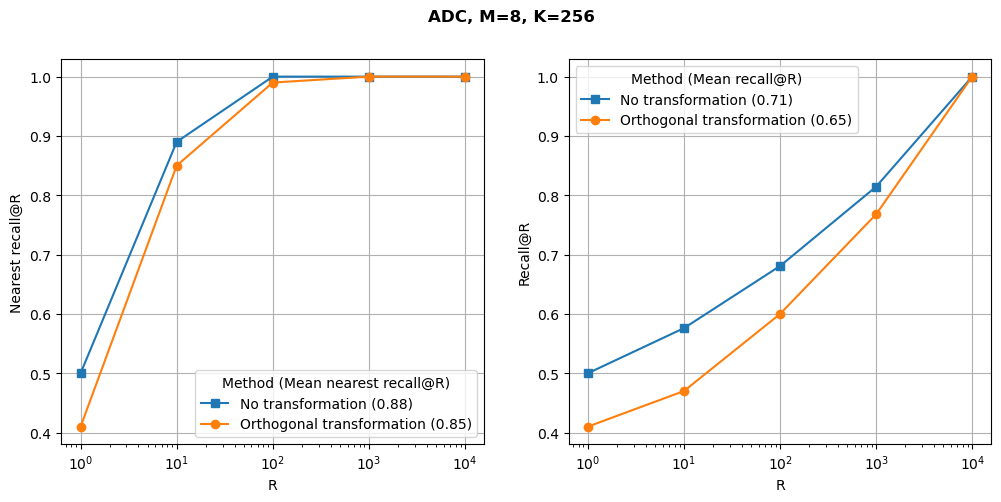

In [44]:
pq_orth = PQ(M=M, K=K, seed=RANDOM_SEED, orth_transf=True)
pq_orth.train(tr_data, add=False)
pq_orth.add(search_data, compute_distortions=False)
results_pq_orth = compute_recall(pq_orth, R, queries, exact_ranks, correct=False, sym=False)
results_pq_orth["search_NMSE"] = NMSE(search_data, pq_orth.decompress(pq_orth.pqcode))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-s', label=f"No transformation ({np.mean(results_pq['nearest_asym_recall_mean']):.2f})")
axs[0].plot(R, results_pq_orth["nearest_asym_recall_mean"], '-o', label=f"Orthogonal transformation ({np.mean(results_pq_orth['nearest_asym_recall_mean']):.2f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R, results_pq["asym_recall_mean"], '-s', label=f"No transformation ({np.mean(results_pq['asym_recall_mean']):.2f})")
axs[1].plot(R, results_pq_orth["asym_recall_mean"], '-o', label=f"Orthogonal transformation ({np.mean(results_pq_orth['asym_recall_mean']):.2f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, M={M}, K={K}", fontweight='bold');

Displaying NMSE on search data:

In [45]:
pd.DataFrame(
    [results_pq, results_pq_orth,],
    index=["No transformation", "Orthogonal transformation"]
)[["search_NMSE"]].style.background_gradient(cmap='Blues')

Visualizing KMeans inertia in each subspace:

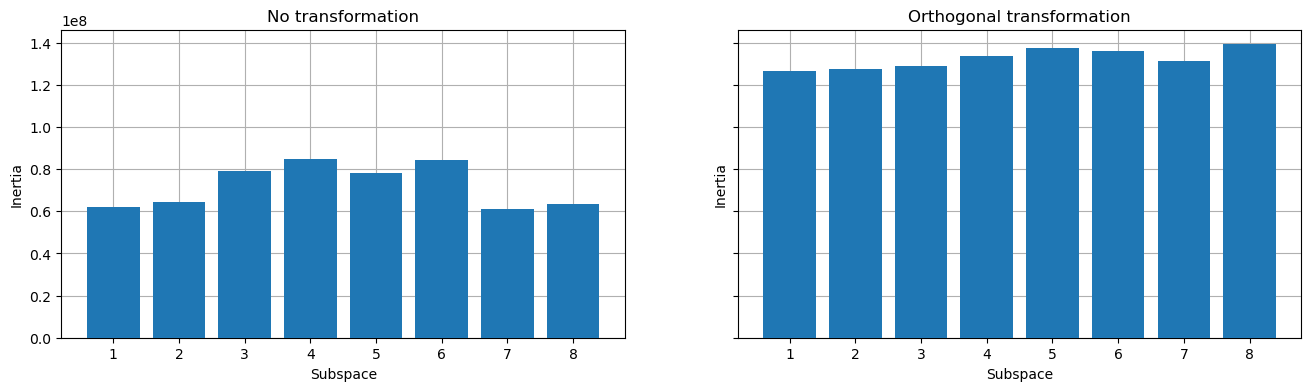

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

axs[0].bar(range(1, results_pq["inertia"].shape[0]+1), results_pq["inertia"], zorder=3)
axs[0].set_xlabel('Subspace')
axs[0].set_ylabel('Inertia')
axs[0].set_title('No transformation')
axs[0].set_xticks(range(1, results_pq["inertia"].shape[0]+1))
axs[0].grid(zorder=0)

axs[1].bar(range(1, results_pq_orth["inertia"].shape[0]+1), results_pq_orth["inertia"], zorder=3)
axs[1].set_xlabel('Subspace')
axs[1].set_ylabel('Inertia')
axs[1].set_title('Orthogonal transformation')
axs[1].set_xticks(range(1, M+1))
axs[1].grid(zorder=0)

del pq_orth

In order to reduce the quantization error in each subspace, we implemented the following methods for grouping components:
- Agglomerative Hierarchical clustering of features with different linkage criteria
- KMeans clustering of features
- Spectral Biclustering of the data (clusters vectors and features simultaneously)

Note that the resulting partitions are not necessarily equal in size.

Performing agglomerative hierarchical clustering of features with different linkage criteria and cutting the dendrogram in order to obtain `M` clusters:

In [47]:
algorithms = ["single", "complete", "average", "ward"]
linkages = []
dm = pdist(tr_data.T, metric='euclidean')
for algorithm in algorithms:
    linkage_res = linkage(dm, method=algorithm, metric='euclidean', optimal_ordering=False)
    linkages.append(linkage_res)

ncuts = tr_data.shape[1]
clusters_info = {}
clusters_info['method'] = []
clusters_info['cut_height'] = []
clusters_info['clusters_sizes'] = []
clusters_info['cluster_labels'] = []
clusters_info['silhouette_score'] = []

for i, algorithm in enumerate(algorithms):
    clusters_info['method'].append(algorithm)
    merge_dist = linkages[i][:,2]
    merge_dist_diff = np.array([merge_dist[j + 1] - merge_dist[j] for j in range(len(merge_dist) - 1)])
    sorted_merge_dist_diff_it = np.argsort(-merge_dist_diff)
    
    for j in range(ncuts):
        clusters = np.array(cut_tree(linkages[i], height=merge_dist[sorted_merge_dist_diff_it[j]])).reshape(-1)
        n_clusters = np.unique(clusters).shape[0]
        if n_clusters == M:
            clusters_info['cut_height'].append(merge_dist[sorted_merge_dist_diff_it[j]])
            counts = np.bincount(clusters)
            clusters_info['clusters_sizes'].append(sorted(counts[counts!=0]))
            clusters_info['cluster_labels'].append(clusters)
            silhouette = silhouette_score(tr_data.T, clusters, metric='euclidean')
            clusters_info['silhouette_score'].append(silhouette)
            break

clusters_info_df = pd.DataFrame(clusters_info)
clusters_info_df.set_index(['method'], inplace=True)
clusters_info_df[['cut_height', 'clusters_sizes', 'silhouette_score']]

cut_height                clusters_sizes  silhouette_score
method                                                                
single     6047.197202    [1, 1, 1, 2, 2, 2, 3, 116]          0.002920
complete   9283.884747  [5, 5, 5, 8, 11, 13, 14, 67]          0.122158
average    7457.656212    [2, 4, 5, 5, 7, 9, 16, 80]          0.119407
ward      14360.085456  [5, 5, 8, 9, 14, 19, 27, 41]          0.085685

Plotting the resulting dendrograms:

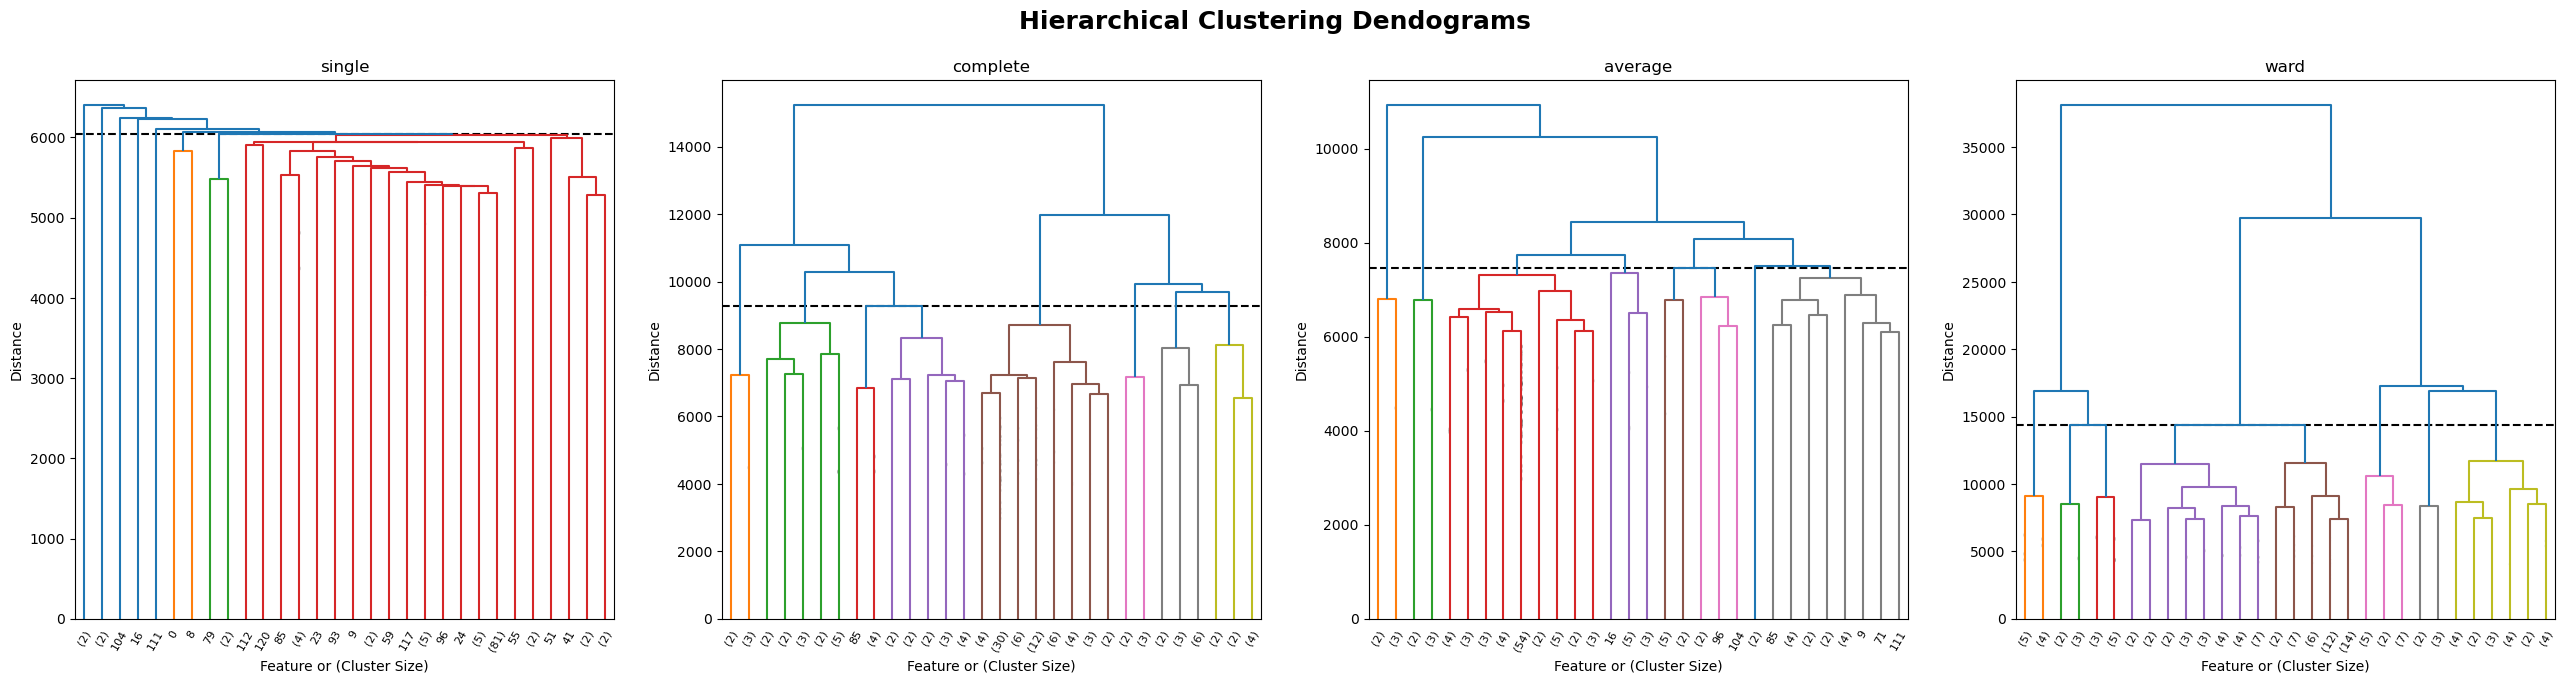

In [48]:
_, axs = plt.subplots(ncols=len(linkages), figsize=(32,7))

thresholds = clusters_info_df['cut_height'].to_numpy()
for i in range(len(linkages)):
    axs[i].set_title(algorithms[i])
    axs[i].set_xlabel('Feature or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(thresholds[i], ls='--', color='k', label='threshold')
    color_threshold = thresholds[i]
    dendrogram(linkages[i], truncate_mode="lastp", p=30, leaf_rotation=60, leaf_font_size=8,
        show_contracted=True, ax=axs[i], color_threshold=color_threshold)

plt.suptitle(('Hierarchical Clustering Dendograms'), fontsize=18, fontweight='bold')
plt.show()

Selecting the best linkage criterion:

In [49]:
best_alg = 'complete' if DATASET == "sift" else 'average'

Evaluating the impact of different component grouping strategies on the search performance:

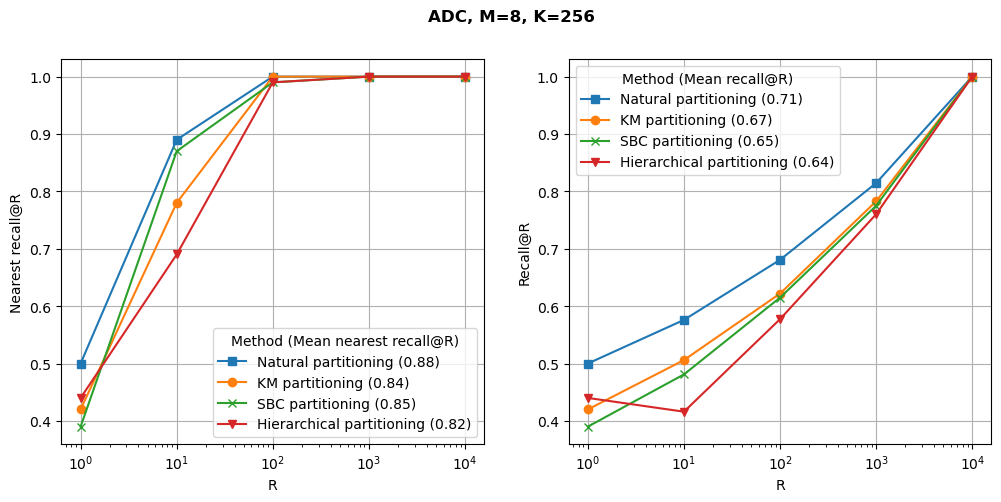

In [50]:
pq_opt_part_custom = PQ(M=M, K=K, seed=RANDOM_SEED, part_alg='custom')
pq_opt_part_custom.train(tr_data, add=False, features_labels=clusters_info_df.loc[best_alg]['cluster_labels'])
pq_opt_part_custom.add(search_data, compute_distortions=False)
results_pq_opt_part_custom = compute_recall(pq_opt_part_custom, R, queries, exact_ranks, correct=False, sym=False)
results_pq_opt_part_custom["search_NMSE"] = NMSE(search_data, pq_opt_part_custom.decompress(pq_opt_part_custom.pqcode))

pq_opt_part_km = PQ(M=M, K=K, seed=RANDOM_SEED, part_alg='km')
pq_opt_part_km.train(tr_data, add=False)
pq_opt_part_km.add(search_data, compute_distortions=False)
results_pq_opt_part_km = compute_recall(pq_opt_part_km, R, queries, exact_ranks, correct=False, sym=False)
results_pq_opt_part_km["search_NMSE"] = NMSE(search_data, pq_opt_part_km.decompress(pq_opt_part_km.pqcode))

pq_opt_part_sbc = PQ(M=M, K=K, seed=RANDOM_SEED, part_alg='sbc')
pq_opt_part_sbc.train(tr_data, add=False)
pq_opt_part_sbc.add(search_data, compute_distortions=False)
results_pq_opt_part_sbc = compute_recall(pq_opt_part_sbc, R, queries, exact_ranks, correct=False, sym=False)
results_pq_opt_part_sbc["search_NMSE"] = NMSE(search_data, pq_opt_part_sbc.decompress(pq_opt_part_sbc.pqcode))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-s', label=f"Natural partitioning ({np.mean(results_pq['nearest_asym_recall_mean']):.2f})")
axs[0].plot(R, results_pq_opt_part_km["nearest_asym_recall_mean"], '-o', label=f"KM partitioning ({np.mean(results_pq_opt_part_km['nearest_asym_recall_mean']):.2f})")
axs[0].plot(R, results_pq_opt_part_sbc["nearest_asym_recall_mean"], '-x', label=f"SBC partitioning ({np.mean(results_pq_opt_part_sbc['nearest_asym_recall_mean']):.2f})")
axs[0].plot(R, results_pq_opt_part_custom["nearest_asym_recall_mean"], '-v', label=f"Hierarchical partitioning ({np.mean(results_pq_opt_part_custom['nearest_asym_recall_mean']):.2f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R, results_pq["asym_recall_mean"], '-s', label=f"Natural partitioning ({np.mean(results_pq['asym_recall_mean']):.2f})")
axs[1].plot(R, results_pq_opt_part_km["asym_recall_mean"], '-o', label=f"KM partitioning ({np.mean(results_pq_opt_part_km['asym_recall_mean']):.2f})")
axs[1].plot(R, results_pq_opt_part_sbc["asym_recall_mean"], '-x', label=f"SBC partitioning ({np.mean(results_pq_opt_part_sbc['asym_recall_mean']):.2f})")
axs[1].plot(R, results_pq_opt_part_custom["asym_recall_mean"], '-v', label=f"Hierarchical partitioning ({np.mean(results_pq_opt_part_custom['asym_recall_mean']):.2f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, M={M}, K={K}", fontweight='bold');

Displaying NMSE on search data:

In [51]:
pd.DataFrame(
    [results_pq, results_pq_opt_part_custom, results_pq_opt_part_km, results_pq_opt_part_sbc],
    index=["No opt.", "Hier.", "KM", "BSC"]
)[["search_NMSE"]].style.background_gradient(cmap='Blues')

Comparing the resulting feature clusters:

In [52]:
sankey_plot(
    [
        pq_opt_part_custom.features_labels.tolist(),
        pq_opt_part_km.features_labels.tolist(),
        pq_opt_part_sbc.features_labels.tolist()
    ],
    labels_titles=["Hier.", "KM", "SBC"],
    title="Column clusters comparison"
)

Visualizing KMeans inertia and the number of features in each subspace:

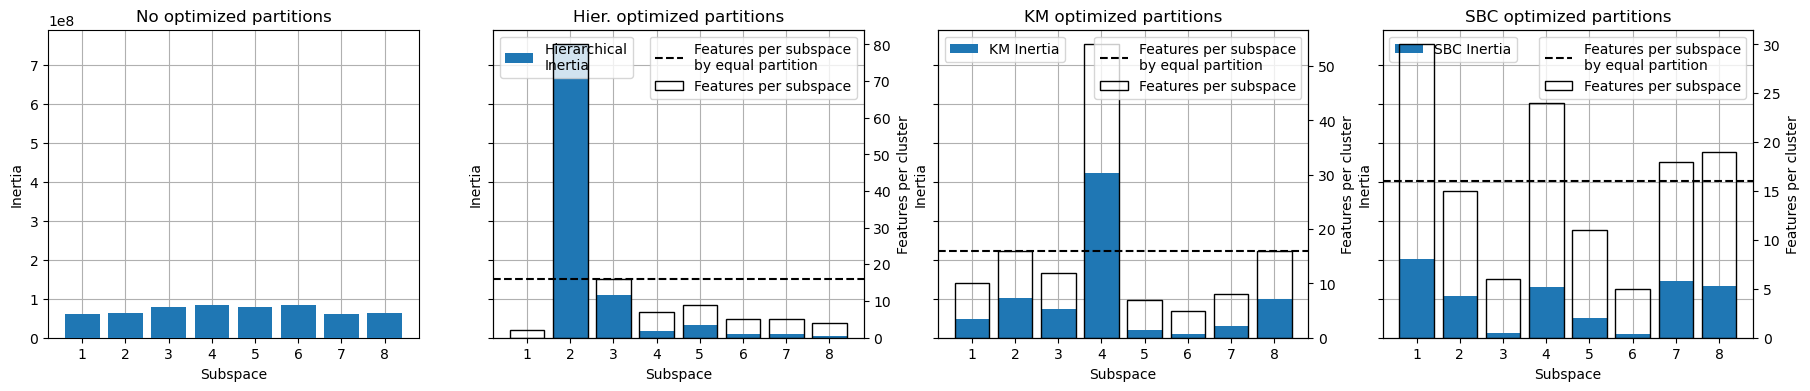

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(22, 4), sharey=True)

data = [
    {
        "inertia": results_pq["inertia"],
        "title": "No optimized partitions",
        "cluster_sizes": None,
        "legend_label": None
    },
    {
        "inertia": results_pq_opt_part_custom["inertia"],
        "title": "Hier. optimized partitions",
        "cluster_sizes": pq_opt_part_custom.features_cluster_sizes,
        "legend_label": "Hierarchical\nInertia"
    },
    {
        "inertia": results_pq_opt_part_km["inertia"],
        "title": "KM optimized partitions",
        "cluster_sizes": pq_opt_part_km.features_cluster_sizes,
        "legend_label": "KM Inertia"
    },
    {
        "inertia": results_pq_opt_part_sbc["inertia"],
        "title": "SBC optimized partitions",
        "cluster_sizes": pq_opt_part_sbc.features_cluster_sizes,
        "legend_label": "SBC Inertia"
    }
]

equal_partition_line = int(tr_data.shape[1] / M)

for i, ax in enumerate(axs):
    plot_data = data[i]
    xticks_range = range(1, len(plot_data["inertia"]) + 1)

    ax.bar(xticks_range, plot_data["inertia"], zorder=3, label=plot_data["legend_label"])
    ax.set_xlabel("Subspace")
    ax.set_ylabel("Inertia")
    ax.set_title(plot_data["title"])
    ax.set_xticks(xticks_range)
    ax.grid(zorder=0)
    if plot_data["legend_label"]:
        ax.legend(loc="upper left")
    
    if plot_data["cluster_sizes"] is not None:
        ax_twin = ax.twinx()
        ax_twin.bar(
            xticks_range, plot_data["cluster_sizes"],
            zorder=3, facecolor="none", edgecolor="black", label="Features per subspace"
        )
        ax_twin.axhline(
            equal_partition_line, color="black", linestyle="--",
            label="Features per subspace\nby equal partition"
        )
        ax_twin.set_ylabel("Features per cluster")
        ax_twin.legend(loc="upper right")

del pq_opt_part_custom
del pq_opt_part_km
del pq_opt_part_sbc


In [54]:
from sklearn.neighbors import KernelDensity
import numpy as np

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(tr_data)
log_density = kde.score_samples(tr_data)
density = np.exp(log_density)
weights = density / np.sum(density)
np.unique(weights)

array([4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
       4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05, 4.e-05,
      

In [55]:
from sklearn.cluster import DBSCAN
import numpy as np

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(tr_data)
labels = dbscan.labels_
weights = np.where(labels == -1, 0.1, 1)
np.unique(weights)

array([0.1])

Plotting the `n`-th nearest neighbor distances of the vectors in the training data for different values of `n`:

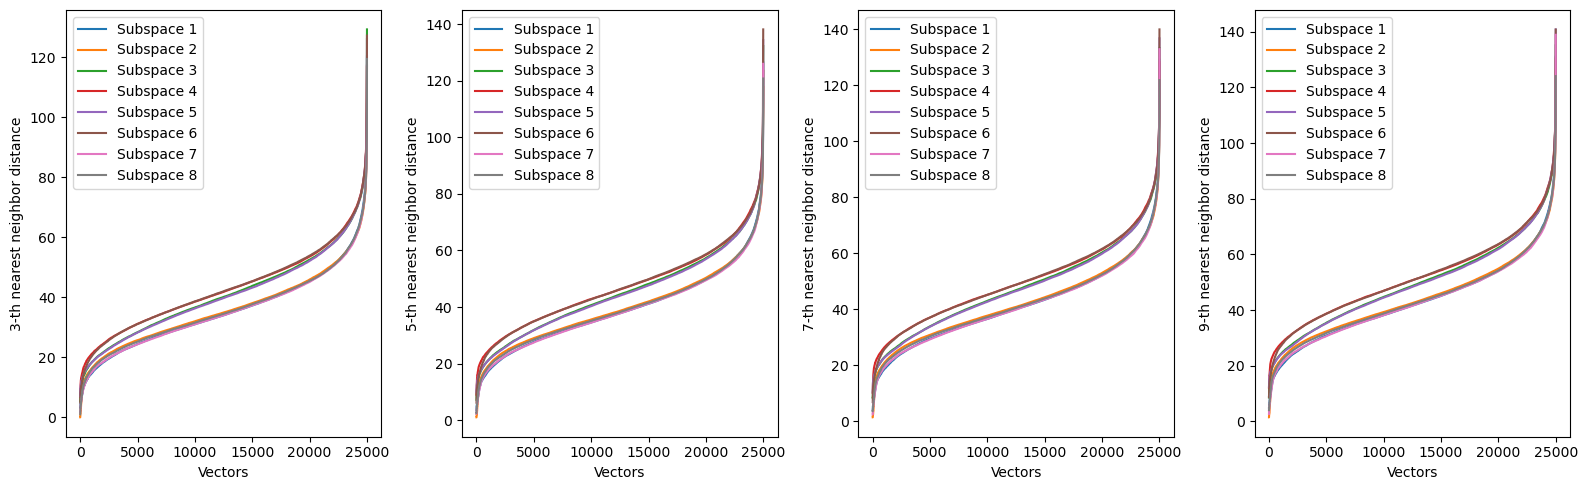

In [56]:
pq_weighted = PQ(M=M, K=K, seed=RANDOM_SEED)

fig, axs = plt.subplots(1, 4, figsize=(16, 5))
pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=3, ax=axs[0])
pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=5, ax=axs[1])
pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=7, ax=axs[2])
pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=9, ax=axs[3])
fig.tight_layout()

Evaluating the impact of weighting samples based on the distance to the neighbor-th nearest neighbor during KMeans training with different values of `n` and weighting methods.

The following weighting methods are considered:
- `'normal'` with `inverse_weights` set to `False`: Weights are distances normalized to [0, 1]
- `'normal'` with `inverse_weights` set to `True`: Weights are 1 - distances normalized to [0, 1]
- `'reciprocal'` with `inverse_weights` set to `True`: Weights are 1 / distances, subsequently normalized to [0, 1] (`'reciprocal'` with `inverse_weights` set to `False` corresponds to `'normal'` with `inverse_weights` set to False)

In [57]:
def compute_weighted_PQ_recall(
    pq, weight_samples, neighbor, inverse_weights, weight_method, R, tr_data,
    search_data, queries, exact_ranks):
    pq.train(
        tr_data, add=False, weight_samples=weight_samples,
        neighbor=neighbor, inverse_weights=inverse_weights,
        weight_method=weight_method)
    pq.add(search_data, compute_distortions=False)
    results = compute_recall(pq, R, queries, exact_ranks, correct=False, sym=False)
    decompressed_search = pq.decompress(pq.pqcode)
    error_search = NMSE(search_data, decompressed_search)
    results["search_NMSE"] = error_search
    return results

neighbors = [3, 5, 7, 9]
weight_methods = ["normal", "reciprocal"]
inverse_weights_opts = [True, False]

search_NMSE_weighted = []
nearest_recall_weithed = []
recall_weighted = []
for neighbor in neighbors:
    for weight_method in weight_methods:
        for inverse_weights in inverse_weights_opts:
            if (weight_method == "reciprocal" and inverse_weights == False):
                continue
            results = compute_weighted_PQ_recall(
                pq_weighted, True, neighbor, inverse_weights, weight_method,
                R_small, tr_data, search_data, queries, exact_ranks)
            keys = {"neighbor": neighbor, "weight_method": weight_method, "inverse_weights": inverse_weights}
            search_NMSE_weighted.append({**keys, "search_NMSE": results["search_NMSE"]})
            nearest_recall_weithed.append({**keys, "nearest_asym_recall_mean": results["nearest_asym_recall_mean"]})
            recall_weighted.append({**keys, "asym_recall_mean": results["asym_recall_mean"]})
del pq_weighted

Plotting the results:

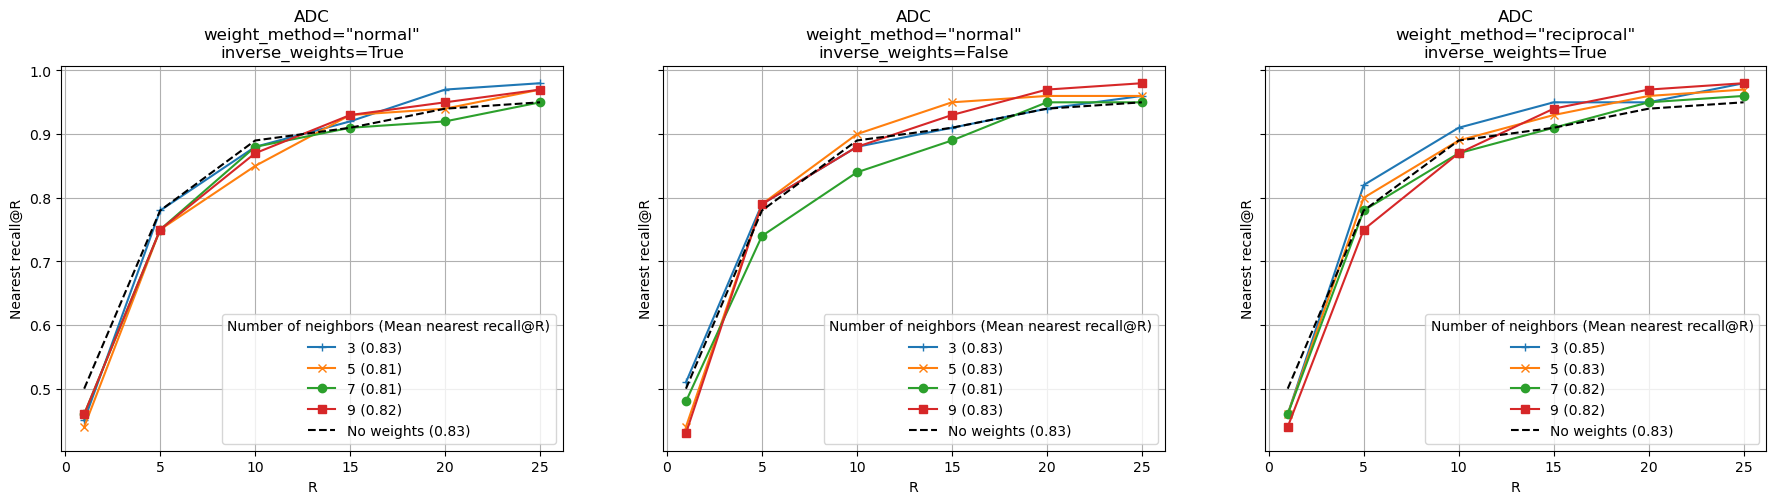

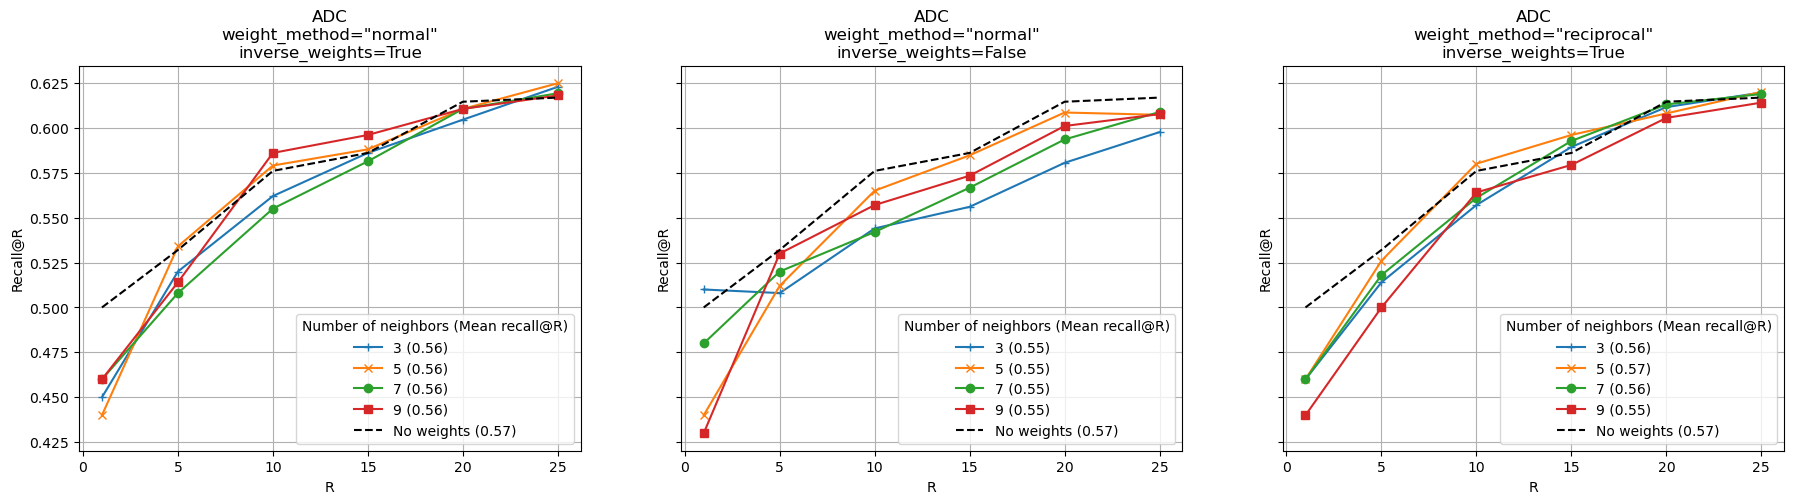

In [58]:
nearest_recall_weithed_df = pd.DataFrame(nearest_recall_weithed)
recall_weithed_df = pd.DataFrame(recall_weighted)

fig, axs = plt.subplots(1, 3, figsize=(22, 5), sharey=True)

i=0
for weight_method in weight_methods:
    for inverse_weights in inverse_weights_opts:
        if (weight_method == "reciprocal" and inverse_weights == False):
            continue
        for j, neighbor in enumerate(neighbors):
            recall = nearest_recall_weithed_df[
                (nearest_recall_weithed_df['neighbor']==neighbor) &
                (nearest_recall_weithed_df['weight_method']==weight_method) &
                (nearest_recall_weithed_df['inverse_weights']==inverse_weights)
            ]['nearest_asym_recall_mean'].values[0]
            axs[i].plot(R_small, recall, label=f"{neighbor} ({np.mean(recall):.2f})", marker=markers[j])
        axs[i].plot(R_small, results_pq_seeds[0]["nearest_asym_recall_mean"], label=f"No weights ({np.mean(results_pq_seeds[0]['nearest_asym_recall_mean']):.2f})", color='black', linestyle='dashed')
        axs[i].set_xlabel('R')
        axs[i].set_ylabel('Nearest recall@R')
        axs[i].title.set_text(f'ADC\nweight_method="{weight_method}"\ninverse_weights={inverse_weights}')
        axs[i].legend(title='Number of neighbors (Mean nearest recall@R)')
        axs[i].grid()
        i+=1

fig, axs = plt.subplots(1, 3, figsize=(22, 5), sharey=True)

i=0
for weight_method in weight_methods:
    for inverse_weights in inverse_weights_opts:
        if (weight_method == "reciprocal" and inverse_weights == False):
            continue
        for j, neighbor in enumerate(neighbors):
            recall = recall_weithed_df[
                    (nearest_recall_weithed_df['neighbor']==neighbor) &
                    (nearest_recall_weithed_df['weight_method']==weight_method) &
                    (nearest_recall_weithed_df['inverse_weights']==inverse_weights)
                ]['asym_recall_mean'].values[0]
            axs[i].plot(R_small, recall, label=f"{neighbor} ({np.mean(recall):.2f})", marker=markers[j])
        axs[i].plot(R_small, results_pq_seeds[0]["asym_recall_mean"], label=f"No weights ({np.mean(results_pq_seeds[0]['asym_recall_mean']):.2f})", color='black', linestyle='dashed')
        axs[i].set_xlabel('R')
        axs[i].set_ylabel('Recall@R')
        axs[i].title.set_text(f'ADC\nweight_method="{weight_method}"\ninverse_weights={inverse_weights}')
        axs[i].legend(title='Number of neighbors (Mean recall@R)')
        axs[i].grid()
        i+=1

Displaying NMSE on search data:

In [59]:
pd.DataFrame(search_NMSE_weighted).style.background_gradient(subset=["search_NMSE"], cmap='Blues')

### Product Quantization with InVerted File index (IVF)

Computing the average recall at various values of `R` for the set of queries on scaled data with different scaling approaches and plotting the results. Here, KMeans inertia (sum of squared distances of samples to their closest cluster center) is computed for the coarse clustering.

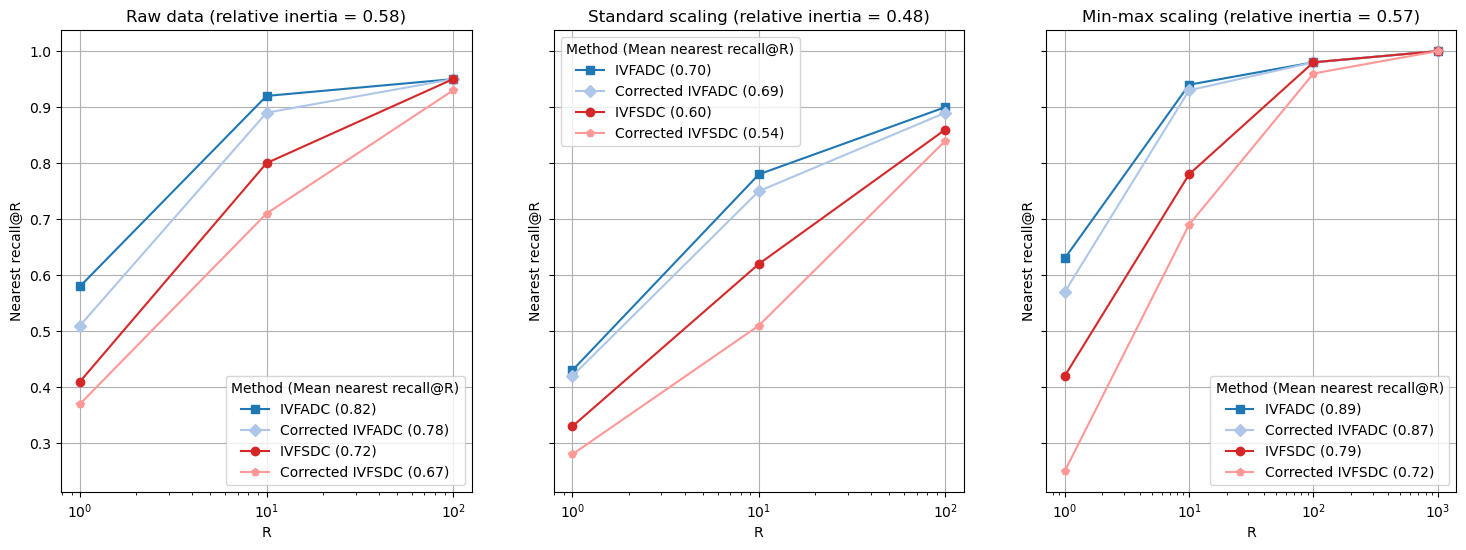

In [60]:
ivf_std = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_std.train(tr_data_std, add=False)
ivf_std.add(search_data_std, compute_distortions=True)
results_ivf_std = compute_recall(ivf_std, R, queries_std, exact_ranks, w=W)
del ivf_std

ivf_minmax = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_minmax.train(tr_data_minmax, add=False)
ivf_minmax.add(search_data_minmax, compute_distortions=True)
results_ivf_minmax = compute_recall(ivf_minmax, R, queries_minmax, exact_ranks, w=W)
del ivf_minmax

def compute_overall_inertia(data):
    mean = np.mean(data, axis=0)
    return np.sum(np.square(data - mean))

overall_inertia = compute_overall_inertia(tr_data)
overall_inertia_std = compute_overall_inertia(tr_data_std)
overall_inertia_minmax = compute_overall_inertia(tr_data_minmax)

scaling_methods_ivf = [
    ("Raw data", results_ivf, overall_inertia),
    ("Standard scaling", results_ivf_std, overall_inertia_std),
    ("Min-max scaling", results_ivf_minmax, overall_inertia_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data, overall_inertia) in zip(axs, scaling_methods_ivf):
    ax.plot(R, data["nearest_asym_recall_mean"], '-s', label=f"IVFADC ({np.nanmean(data['nearest_asym_recall_mean']):.2f})", color=tab20(0))
    ax.plot(R, data["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected IVFADC ({np.nanmean(data['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
    ax.plot(R, data["nearest_sym_recall_mean"], '-o', label=f"IVFSDC ({np.nanmean(data['nearest_sym_recall_mean']):.2f})", color=tab20(6))
    ax.plot(R, data["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected IVFSDC ({np.nanmean(data['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Nearest recall@R')
    ax.set_title(f"{title} (relative inertia = {1-(data['inertia'] / overall_inertia):.2f})")
    ax.legend(title="Method (Mean nearest recall@R)")
    ax.grid()
plt.show()

Comparing the search performance and training time when using KMeans and Bisecting KMeans for the coarse clustering with different parameters:

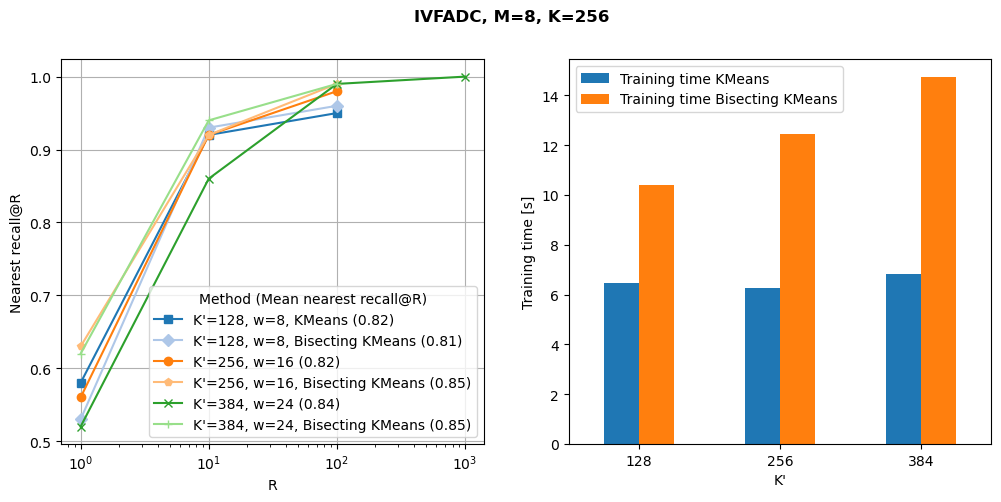

In [61]:
def compute_IVF_recall(
        M, K, KP, W, bisectingkmeans, tr_data, search_data, queries,
        exact_ranks, seed=RANDOM_SEED):
    
    ivf = IVF(Kp=KP, M=M, K=K, seed=seed, bisectingkmeans=bisectingkmeans)
    start_training_ivf = time.time()
    ivf.train(tr_data, add=False)
    training_ivf = time.time() - start_training_ivf
    ivf.add(search_data, compute_distortions=False)
    results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W, correct=False, sym=False)
    return results_ivf, training_ivf

results_ivf_bis, training_ivf_bis = compute_IVF_recall(
    M, K, KP, W, True, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_double, training_ivf_double = compute_IVF_recall(
    M, K, KP*2, W*2, False, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_bis_double, training_ivf_bis_double = compute_IVF_recall(
    M, K, KP*2, W*2, True, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_triple, training_ivf_triple = compute_IVF_recall(
    M, K, KP*3, W*3, False, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_bis_triple, training_ivf_bis_triple = compute_IVF_recall(
    M, K, KP*3, W*3, True, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"K'={KP}, w={W}, KMeans ({np.nanmean(results_ivf['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_ivf_bis["nearest_asym_recall_mean"], '-D', label=f"K'={KP}, w={W}, Bisecting KMeans ({np.nanmean(results_ivf_bis['nearest_asym_recall_mean']):.2f})", color=tab20(1))
axs[0].plot(R, results_ivf_double["nearest_asym_recall_mean"], '-o', label=f"K'={KP*2}, w={W*2} ({np.nanmean(results_ivf_double['nearest_asym_recall_mean']):.2f})", color=tab20(2))
axs[0].plot(R, results_ivf_bis_double["nearest_asym_recall_mean"], '-p', label=f"K'={KP*2}, w={W*2}, Bisecting KMeans ({np.nanmean(results_ivf_bis_double['nearest_asym_recall_mean']):.2f})", color=tab20(3))
axs[0].plot(R, results_ivf_triple["nearest_asym_recall_mean"], '-x', label=f"K'={KP*3}, w={W*3} ({np.nanmean(results_ivf_triple['nearest_asym_recall_mean']):.2f})", color=tab20(4))
axs[0].plot(R, results_ivf_bis_triple["nearest_asym_recall_mean"], '-+', label=f"K'={KP*3}, w={W*3}, Bisecting KMeans ({np.nanmean(results_ivf_bis_triple['nearest_asym_recall_mean']):.2f})", color=tab20(5))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

colors = [tab20(0), tab20(4), tab20(8)]
df = pd.DataFrame({
    "K'": [KP, KP*2, KP*3],
    "Training time KMeans": [training_ivf, training_ivf_double, training_ivf_triple],
    "Training time Bisecting KMeans": [training_ivf_bis, training_ivf_bis_double, training_ivf_bis_triple]
    })
df.set_index("K'", inplace=True)
df.plot.bar(rot=0, color=[tab20(0), tab20(2)], ax=axs[1])
axs[1].set_ylabel("Training time [s]");

fig.suptitle(f"IVFADC, M={M}, K={K}", fontweight='bold');

From [scikit-learn documentation](https://scikit-learn.org/1.5/modules/clustering.html#bisecting-k-means):

> The BisectingKMeans is an iterative variant of KMeans, using divisive hierarchical clustering. Instead of creating all centroids at once, centroids are picked progressively based on a previous clustering: a cluster is split into two new clusters repeatedly until the target number of clusters is reached. BisectingKMeans is more efficient than KMeans when the number of clusters is large since it only works on a subset of the data at each bisection while KMeans always works on the entire dataset."